### Ver4 Enhanced with Spectral Attention and Multi-Objective Loss

Update di versi 4 :
- Ada Spectral Attention
- Ada Multi-Objective Loss
- Ada mekanisme early stopping
- Beberapa peningkatan di proses evaluasi

In [1]:
# ===========================================
# Cell 1. Import Library dan Setup Environment
# ===========================================

import os
import json
import random
from pathlib import Path
from collections import Counter

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from sklearn.metrics import confusion_matrix, f1_score, accuracy_score
from sklearn.preprocessing import MinMaxScaler
from scipy.ndimage import distance_transform_edt

# Gunakan GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device yang digunakan:", device)

# Monitor GPU memory
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Total Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")


Device yang digunakan: cuda
GPU: NVIDIA GeForce RTX 4080 SUPER
Total Memory: 17.17 GB


In [2]:
# ===========================================
# Cell 2. Fungsi Bantuan Umum
# ===========================================

from matplotlib.colors import ListedColormap

def seed_everything(seed=42):
    """Menetapkan seed random agar hasil eksperimen bisa direplikasi"""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

seed_everything(42)

def visualize_tile(x_tile, y_true=None, y_pred=None, json_path=None, class_names=None, idx=0):
    """Menampilkan citra tile beserta mask ground-truth dan prediksi"""
    if isinstance(x_tile, torch.Tensor):
        x = x_tile.cpu().numpy()
        x = np.transpose(x, (1,2,0))  # ubah dari [B,H,W] -> [H,W,B]
    else:
        x = x_tile

    # menampilkan pseudo-RGB (karena data hyperspectral)
    B = x.shape[2]
    b1, b2, b3 = int(B*0.05), int(B*0.5), int(B*0.9)
    rgb = x[..., [b1, b2, b3]]
    rgb_norm = (rgb - rgb.min()) / (rgb.max() - rgb.min() + 1e-9)

    # Coba baca colormap dari file JSON
    if json_path and os.path.exists(json_path):
        with open(json_path, "r") as f:
            label_info = json.load(f)
        custom_colors = [c["color"][:7] for c in label_info]
        cmap = ListedColormap(custom_colors)
    else:
        print("File json tidak terbaca, menggunakan cmap tab20")
        cmap = "tab20"  # fallback

    # Visualisasi
    plt.figure(figsize=(12,4))
    plt.subplot(1,3,1); plt.imshow(rgb_norm); plt.title("Citra (Pseudo-RGB)")
    if y_true is not None:
        plt.subplot(1,3,2); plt.imshow(y_true, cmap=cmap); plt.title("Ground Truth")
    if y_pred is not None:
        plt.subplot(1,3,3); plt.imshow(y_pred, cmap=cmap); plt.title("Prediksi")
    plt.tight_layout()
    plt.show()


In [3]:
# ===========================================
# Cell 3. Dataset Loader (Same as ver3)
# ===========================================

def load_label_mapping(json_path):
    """Membaca file label_classes.json untuk mapping id ke nama kelas"""
    with open(json_path, 'r', encoding='utf-8') as f:
        data = json.load(f)
    idx_to_name = {i: item["name"] for i, item in enumerate(data)}
    return idx_to_name

def normalize_reflectance(cube):
    """Menormalkan reflektansi 0-1 per tile, hemat RAM, aman untuk mmap read-only."""
    if not cube.flags.writeable:
        cube = cube.astype(np.float32, copy=True)

    if cube.dtype != np.float32:
        cube = cube.astype(np.float32, copy=False)

    np.nan_to_num(cube, copy=False)

    min_val = np.nanmin(cube)
    max_val = np.nanmax(cube)
    if max_val > min_val:
        cube -= min_val
        cube /= (max_val - min_val + 1e-8)

    return cube


class SeaweedDataset(Dataset):
    """Dataset hemat memori berbasis file .npy hasil konversi."""
    def __init__(self, data_files, label_map, tile_size=64, normalize=True, label_remap=None, augment=False):
        self.data_files = data_files
        self.label_map = label_map
        self.tile_size = tile_size
        self.normalize = normalize
        self.label_remap = label_remap
        self.augment = augment # Addt - flag augmentasi

        # Daftar pasangan (file_x, file_y)
        self.pairs = []
        for f in data_files:
            if f.endswith("_x.npy"):
                fy = f.replace("_x.npy", "_y.npy")
                if os.path.exists(fy):
                    self.pairs.append((f, fy))
        
        # Pre-filter tile kosong
        self.index = []
        print("[INFO] Pre-filtering empty tiles...")
        
        empty_count = 0
        valid_count = 0
        
        for file_idx, (fx, fy) in enumerate(self.pairs):
            x = np.load(fx, mmap_mode="r")
            y = np.load(fy, mmap_mode="r")
            H, W, _ = x.shape
            
            for i in range(0, H - tile_size + 1, tile_size):
                for j in range(0, W - tile_size + 1, tile_size):
                    y_tile = y[i:i+tile_size, j:j+tile_size]
                    
                    if np.any(y_tile > 0):
                        self.index.append((file_idx, i, j))
                        valid_count += 1
                    else:
                        empty_count += 1
            del x, y
            
        print(f"[INFO] Total tile valid: {valid_count}")
        print(f"[INFO] Total tile empty (filtered): {empty_count}")
        print(f"[INFO] Ratio valid/total: {valid_count/(valid_count+empty_count)*100:.2f}%")
        print(f"[INFO] Total tile terdaftar: {len(self.index)} dari {len(self.pairs)} file")

    def __len__(self):
        return len(self.index)

    def __getitem__(self, idx):
        file_idx, i, j = self.index[idx]
        fx, fy = self.pairs[file_idx]
        
        # Memuat tile menggunakan mmap
        x = np.load(fx, mmap_mode="r")[i:i+self.tile_size, j:j+self.tile_size, :]
        y = np.load(fy, mmap_mode="r")[i:i+self.tile_size, j:j+self.tile_size]

        if self.normalize:
            x = normalize_reflectance(x)

        # REMAP label bila mapping diberikan
        if self.label_remap is not None:
            y_remap = np.zeros_like(y, dtype=np.int64)
            for orig_label, new_idx in self.label_remap.items():
                y_remap[y == orig_label] = new_idx
            y = y_remap
        else:
            y = y.astype(np.int64)

        # Konversi ke tensor
        x_tensor = torch.tensor(x.transpose(2, 0, 1), dtype=torch.float32)
        y_tensor = torch.tensor(y, dtype=torch.long)

        # Addt - Data Augmentation (hanya untuk training)
        if self.augment:
            # Random horizontal flip (50% chance)
            if random.random() > 0.5:
                x_tensor = torch.flip(x_tensor, [2])  # Flip width dimension
                y_tensor = torch.flip(y_tensor, [1])
            
            # Random vertical flip (50% chance)
            if random.random() > 0.5:
                x_tensor = torch.flip(x_tensor, [1])  # Flip height dimension
                y_tensor = torch.flip(y_tensor, [0])
            
            # Random rotation 90/180/270 (25% chance each)
            k = random.choice([0, 1, 2, 3])  # 0=no rotation, 1=90°, 2=180°, 3=270°
            if k > 0:
                x_tensor = torch.rot90(x_tensor, k, [1, 2])  # Rotate H,W dims
                y_tensor = torch.rot90(y_tensor, k, [0, 1])

        return x_tensor, y_tensor


def detect_actual_classes(pairs):
    """Scan semua file y.npy untuk mendeteksi kelas yang benar-benar ada"""
    found = set()
    for _, fy in pairs:
        y = np.load(fy, mmap_mode="r")
        found |= set(np.unique(y))
    found = sorted(list(found))
    print(f"[INFO] Kelas AKTUAL yang ditemukan di dataset: {found}")
    return found

In [4]:
# ===========================================
# Cell 4. NOVELTY 1: Spectral Self-Attention Module
# ===========================================

class SpectralAttention(nn.Module):
    """
    Spectral Self-Attention Module
    Adaptively learns importance weights for spectral channels
    """
    def __init__(self, in_channels, reduction=16):
        super().__init__()
        # Squeeze: Global spatial pooling
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)
        
        # Excitation: Fully connected layers
        self.fc = nn.Sequential(
            nn.Linear(in_channels, in_channels // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(in_channels // reduction, in_channels, bias=False)
        )
        
        # Sigmoid activation for attention weights
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        """
        Args:
            x: [B, C, H, W] - feature map
        Returns:
            out: [B, C, H, W] - attention-weighted feature map
            attention_weights: [B, C] - learned spectral attention weights
        """
        B, C, H, W = x.size()
        
        # Squeeze: aggregate spatial information
        avg_out = self.avg_pool(x).view(B, C)
        max_out = self.max_pool(x).view(B, C)
        
        # Excitation: learn channel importance
        avg_weight = self.fc(avg_out)
        max_weight = self.fc(max_out)
        
        # Combine and normalize
        attention_weights = self.sigmoid(avg_weight + max_weight)
        
        # Apply attention
        out = x * attention_weights.view(B, C, 1, 1)
        
        return out, attention_weights

In [5]:
# ===========================================
# Cell 5. NOVELTY 2: Multi-Objective Loss Function
# ===========================================

# addt - Focal Loss for CE (advanced opt for CE)
class FocalLoss(nn.Module):
    """
    Focal Loss for addressing class imbalance
    Down-weights easy examples and focuses on hard negatives
    """
    def __init__(self, alpha=None, gamma=2.0, ignore_index=0):
        super().__init__()
        self.alpha = alpha  # Class weights
        self.gamma = gamma  # Focusing parameter
        self.ignore_index = ignore_index
    
    def forward(self, pred, target):
        """
        Args:
            pred: [B, C, H, W] - logits
            target: [B, H, W] - ground truth
        """
        # Compute cross-entropy
        ce_loss = F.cross_entropy(pred, target, weight=self.alpha, 
                                  ignore_index=self.ignore_index, reduction='none')
        
        # Get probabilities
        pt = torch.exp(-ce_loss)
        
        # Compute focal loss
        focal_loss = ((1 - pt) ** self.gamma * ce_loss).mean()
        
        return focal_loss

class DiceLoss(nn.Module):
    """
    Dice Loss for region-level consistency
    Good for handling class imbalance
    """
    def __init__(self, smooth=1.0, ignore_index=0):
        super().__init__()
        self.smooth = smooth
        self.ignore_index = ignore_index
    
    def forward(self, pred, target):
        """
        Args:
            pred: [B, C, H, W] - logits
            target: [B, H, W] - ground truth
        """
        pred = F.softmax(pred, dim=1)
        target_one_hot = F.one_hot(target, num_classes=pred.shape[1]).permute(0, 3, 1, 2).float()
        
        # Ignore background
        if self.ignore_index is not None:
            mask = (target != self.ignore_index).unsqueeze(1).float()
            pred = pred * mask
            target_one_hot = target_one_hot * mask
        
        # Calculate Dice coefficient
        intersection = (pred * target_one_hot).sum(dim=(2, 3))
        union = pred.sum(dim=(2, 3)) + target_one_hot.sum(dim=(2, 3))
        
        dice = (2. * intersection + self.smooth) / (union + self.smooth)
        
        # Return 1 - Dice as loss
        return 1 - dice.mean()


class BoundaryLoss(nn.Module):
    """
    Boundary Loss for edge precision
    Penalizes errors near object boundaries
    """
    def __init__(self, ignore_index=0):
        super().__init__()
        self.ignore_index = ignore_index
    
    def forward(self, pred, target):
        """
        Args:
            pred: [B, C, H, W] - logits
            target: [B, H, W] - ground truth
        """
        pred = F.softmax(pred, dim=1)
        pred_classes = pred.argmax(dim=1)
        
        total_loss = 0
        batch_size = target.shape[0]
        
        for b in range(batch_size):
            target_np = target[b].cpu().numpy()
            pred_np = pred_classes[b].cpu().numpy()
            
            # Skip if all background
            if np.all(target_np == self.ignore_index):
                continue
            
            # Compute boundary distance transform
            boundary_target = self._compute_boundary_distance(target_np, self.ignore_index)
            boundary_pred = self._compute_boundary_distance(pred_np, self.ignore_index)
            
            # L1 distance between boundaries
            boundary_target_tensor = torch.from_numpy(boundary_target).float().to(pred.device)
            boundary_pred_tensor = torch.from_numpy(boundary_pred).float().to(pred.device)
            
            loss = torch.abs(boundary_target_tensor - boundary_pred_tensor).mean()
            total_loss += loss
        
        return total_loss / batch_size if batch_size > 0 else torch.tensor(0.0, device=pred.device)
    
    def _compute_boundary_distance(self, mask, ignore_index):
        """Compute distance transform from boundaries"""
        # Create binary mask (ignore background)
        binary_mask = (mask != ignore_index).astype(np.uint8)
        
        # Compute boundaries using morphological operations
        from scipy.ndimage import binary_erosion
        eroded = binary_erosion(binary_mask)
        boundary = binary_mask - eroded
        
        # Distance transform
        if boundary.sum() > 0:
            dist = distance_transform_edt(1 - boundary)
        else:
            dist = np.zeros_like(boundary, dtype=np.float32)
        
        return dist


class HybridLoss(nn.Module):
    """
    Multi-Objective Hybrid Loss
    Combines: Focal Loss + Dice + Boundary
    """
    def __init__(self, weight_ce=1.0, weight_dice=1.0, weight_boundary=0.1,  # weight_boundary diturunkan dari 0.5
                 class_weights=None, ignore_index=0, focal_gamma=2.0):       # arg label_smoothing diganti dengan focal_gamma karena CE diganti Focal
        super().__init__()
        self.weight_ce = weight_ce # istilah yang digunakan masih 'ce', meski aktualnya adalah Focal 
        self.weight_dice = weight_dice
        self.weight_boundary = weight_boundary
        
        # Updt - Menggunakan Focal Loss menggantikan standard CE
        self.ce_loss = FocalLoss(
            alpha=class_weights, 
            gamma=focal_gamma,
            ignore_index=ignore_index
        )
        self.dice_loss = DiceLoss(ignore_index=ignore_index)
        self.boundary_loss = BoundaryLoss(ignore_index=ignore_index)
    
    def forward(self, pred, target):
        """
        Args:
            pred: [B, C, H, W] - logits
            target: [B, H, W] - ground truth
        Returns:
            total_loss: weighted combination of losses
            loss_dict: individual loss components for logging
        """
        # Compute individual losses
        loss_ce = self.ce_loss(pred, target)
        loss_dice = self.dice_loss(pred, target)
        loss_boundary = self.boundary_loss(pred, target)
        
        # Weighted combination
        total_loss = (
            self.weight_ce * loss_ce +
            self.weight_dice * loss_dice +
            self.weight_boundary * loss_boundary
        )
        
        # Return dictionary for logging
        loss_dict = {
            'total': total_loss.item(),
            'focal': loss_ce.item(),  # Renamed from 'ce' to 'focal'
            'dice': loss_dice.item(),
            'boundary': loss_boundary.item()
        }
        
        return total_loss, loss_dict

In [6]:
# ===========================================
# Cell 6. Enhanced HybridSN with Spectral Attention
# ===========================================

class SpectralAttentionHybridSN(nn.Module):
    """
    Enhanced HybridSN with Spectral Self-Attention
    Architecture:
    1. 3D CNN for spectral-spatial feature extraction
    2. Spectral Attention Module (NOVELTY 1)
    3. 2D CNN for refined spatial processing
    4. Fully convolutional output for segmentation
    """
    def __init__(self, in_bands=300, num_classes=7, attention_reduction=16):
        super().__init__()
        
        # 3D Convolution layers
        self.conv3d_1 = nn.Conv3d(1, 16, (7,3,3), padding=(0,1,1))
        self.bn3d_1 = nn.BatchNorm3d(16)
        
        self.conv3d_2 = nn.Conv3d(16, 32, (5,3,3), padding=(0,1,1))
        self.bn3d_2 = nn.BatchNorm3d(32)
        
        self.conv3d_3 = nn.Conv3d(32, 64, (3,3,3), padding=(0,1,1))
        self.bn3d_3 = nn.BatchNorm3d(64)
        
        # Spectral pooling
        self.spectral_pool = nn.AdaptiveAvgPool3d((8, None, None))
        
        # Calculate 2D input channels
        self.flatten_channels = 64 * 8  # 512 channels
        
        # NOVELTY 1: Spectral Attention Module
        self.spectral_attention = SpectralAttention(
            in_channels=self.flatten_channels,
            reduction=attention_reduction
        )
        
        # 2D Convolution layers
        self.conv2d_1 = nn.Conv2d(self.flatten_channels, 256, 3, padding=1)
        self.bn2d_1 = nn.BatchNorm2d(256)
        self.dropout1 = nn.Dropout2d(0.3)
        
        self.conv2d_2 = nn.Conv2d(256, 128, 3, padding=1)
        self.bn2d_2 = nn.BatchNorm2d(128)
        self.dropout2 = nn.Dropout2d(0.3)
        
        self.conv2d_3 = nn.Conv2d(128, 64, 3, padding=1)
        self.bn2d_3 = nn.BatchNorm2d(64)
        
        # Classifier
        self.classifier = nn.Conv2d(64, num_classes, 1)
        
        # For attention visualization
        self.last_attention_weights = None

    def forward(self, x):
        """
        Args:
            x: [B, Bands, H, W] - input hyperspectral cube
        Returns:
            out: [B, num_classes, H, W] - segmentation logits
        """
        B, Bands, H, W = x.shape
        
        # 3D CNN processing
        x3 = x.unsqueeze(1)  # [B, 1, Bands, H, W]
        x3 = F.relu(self.bn3d_1(self.conv3d_1(x3)))
        x3 = F.relu(self.bn3d_2(self.conv3d_2(x3)))
        x3 = F.relu(self.bn3d_3(self.conv3d_3(x3)))
        
        # Spectral pooling
        x3 = self.spectral_pool(x3)  # [B, 64, 8, H, W]
        
        # Reshape to 2D
        B, C3, reduced_spec, H, W = x3.shape
        x2 = x3.view(B, C3 * reduced_spec, H, W)  # [B, 512, H, W]
        
        # NOVELTY 1: Apply Spectral Attention
        x2, attention_weights = self.spectral_attention(x2)
        self.last_attention_weights = attention_weights  # Save for visualization
        
        # 2D CNN processing
        x2 = self.dropout1(F.relu(self.bn2d_1(self.conv2d_1(x2))))
        x2 = self.dropout2(F.relu(self.bn2d_2(self.conv2d_2(x2))))
        x2 = F.relu(self.bn2d_3(self.conv2d_3(x2)))
        
        # Classification
        out = self.classifier(x2)  # [B, num_classes, H, W]
        
        return out
    
    def get_attention_weights(self):
        """Return last computed attention weights for visualization"""
        return self.last_attention_weights

In [7]:
# ===========================================
# Cell 7. Load Dataset dan Splitting
# ===========================================

data_dir = "../data/npy_converted"
label_json_path = "../data/annotation/segmentation_masks/label_classes.json"

label_map = load_label_mapping(label_json_path)
print(f"Jumlah total kelas di JSON: {len(label_map)}")

# Ambil semua file _x.npy
all_x_files = sorted([os.path.join(data_dir, f) for f in os.listdir(data_dir) if f.endswith("_x.npy")])
pairs = [(fx, fx.replace("_x.npy", "_y.npy")) for fx in all_x_files if os.path.exists(fx.replace("_x.npy", "_y.npy"))]

print(f"Total pasangan file X-Y ditemukan: {len(pairs)}")

# Split deterministik berbasis urutan nama (11 train, 5 val, 2 test)
train_pairs = pairs[:11]
val_pairs   = pairs[11:16]
test_pairs  = pairs[16:]

print("\n=== FINAL SPLIT PER FILE ===")
print(f"Train : {len(train_pairs)}")
print(f"Val   : {len(val_pairs)}")
print(f"Test  : {len(test_pairs)}")

# DETEKSI kelas aktual
actual_classes = detect_actual_classes(train_pairs + val_pairs + test_pairs)
orig_classes = [int(x) for x in actual_classes]
label_remap = {orig: idx for idx, orig in enumerate(orig_classes)}
print(f"[INFO] Label remap (orig -> new): {label_remap}")

# Updt - Tile size increased to 64
TILE_SIZE = 64  # Increased from 32

train_dataset = SeaweedDataset([p[0] for p in train_pairs], label_map, tile_size=TILE_SIZE, label_remap=label_remap, augment=True) # augment=True
val_dataset   = SeaweedDataset([p[0] for p in val_pairs], label_map, tile_size=TILE_SIZE, label_remap=label_remap, augment=False) # augment=False for Val
test_dataset  = SeaweedDataset([p[0] for p in test_pairs], label_map, tile_size=TILE_SIZE, label_remap=label_remap, normalize=False, augment=False) # augment=False for Test

# Hitung class weights
counter = Counter()
for _, fy in train_pairs:
    y = np.load(fy, mmap_mode="r")
    for orig, new in label_remap.items():
        cnt = int((y == orig).sum())
        counter[new] += cnt

print(f"[INFO] Pixel counts per class: {dict(counter)}")

counts = np.array([counter.get(i, 0) for i in range(len(label_remap))], dtype=np.float64)
eps = 1e-6
inv_freq = 1.0 / (counts + eps)
inv_freq = inv_freq / np.mean(inv_freq)
inv_freq[0] = 0.0  # ignore background

# Apply sqrt smoothing
class_weights_np = np.sqrt(inv_freq).astype(np.float32)
print(f"[INFO] Smoothed class weights: {class_weights_np}")

num_classes_actual = len(label_remap)
print(f"\nTotal TILE train: {len(train_dataset)}, val: {len(val_dataset)}, test: {len(test_dataset)}")

Jumlah total kelas di JSON: 41
Total pasangan file X-Y ditemukan: 18

=== FINAL SPLIT PER FILE ===
Train : 11
Val   : 5
Test  : 2
[INFO] Kelas AKTUAL yang ditemukan di dataset: [np.int32(0), np.int32(8), np.int32(12), np.int32(13), np.int32(14), np.int32(18), np.int32(38)]
[INFO] Label remap (orig -> new): {0: 0, 8: 1, 12: 2, 13: 3, 14: 4, 18: 5, 38: 6}
[INFO] Pre-filtering empty tiles...
[INFO] Total tile valid: 1513
[INFO] Total tile empty (filtered): 3037
[INFO] Ratio valid/total: 33.25%
[INFO] Total tile terdaftar: 1513 dari 11 file
[INFO] Pre-filtering empty tiles...
[INFO] Total tile valid: 1520
[INFO] Total tile empty (filtered): 622
[INFO] Ratio valid/total: 70.96%
[INFO] Total tile terdaftar: 1520 dari 5 file
[INFO] Pre-filtering empty tiles...
[INFO] Total tile valid: 437
[INFO] Total tile empty (filtered): 221
[INFO] Ratio valid/total: 66.41%
[INFO] Total tile terdaftar: 437 dari 2 file
[INFO] Pixel counts per class: {0: 14185638, 1: 840140, 2: 1566138, 3: 808104, 4: 36978, 

In [8]:
# ===========================================
# Cell 8. Initialize Model with Spectral Attention
# ===========================================

# Ambil jumlah band dari data
sample_x = np.load(train_pairs[0][0], mmap_mode="r")
in_bands_actual = sample_x.shape[2]
print(f"Band input aktual: {in_bands_actual}")

# Initialize enhanced model
model = SpectralAttentionHybridSN(
    in_bands=in_bands_actual, 
    num_classes=num_classes_actual,
    attention_reduction=16
).to(device)

# Hitung parameter
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\n{'='*60}")
print(f"MODEL ARCHITECTURE")
print(f"{'='*60}")
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")
print(f"Model size: {total_params * 4 / 1e6:.2f} MB (float32)")
print(model)

Band input aktual: 300

MODEL ARCHITECTURE
Total parameters: 1,662,535
Trainable parameters: 1,662,535
Model size: 6.65 MB (float32)
SpectralAttentionHybridSN(
  (conv3d_1): Conv3d(1, 16, kernel_size=(7, 3, 3), stride=(1, 1, 1), padding=(0, 1, 1))
  (bn3d_1): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3d_2): Conv3d(16, 32, kernel_size=(5, 3, 3), stride=(1, 1, 1), padding=(0, 1, 1))
  (bn3d_2): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3d_3): Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(0, 1, 1))
  (bn3d_3): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (spectral_pool): AdaptiveAvgPool3d(output_size=(8, None, None))
  (spectral_attention): SpectralAttention(
    (avg_pool): AdaptiveAvgPool2d(output_size=1)
    (max_pool): AdaptiveMaxPool2d(output_size=1)
    (fc): Sequential(
      (0): Linear(in_features=512, out_features=32, bias=False)
     

In [9]:
# ===========================================
# Cell 9. Setup Training with Multi-Objective Loss + Early Stopping
# ===========================================

import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Enable cudnn benchmark
torch.backends.cudnn.benchmark = True

# Hyperparameters
LR = 1e-4 # Updt - dinaikkan dari 5e-6
WEIGHT_DECAY = 1e-5
BATCH_SIZE = 1
ACCUMULATION_STEPS = 4
CLIP_NORM = 0.5

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=True)

# NOVELTY 2: Multi-Objective Hybrid Loss
weight_tensor = torch.from_numpy(class_weights_np).to(device)
criterion = HybridLoss(
    weight_ce=1.0,          # Focal Loss weight
    weight_dice=1.0,        # Dice Loss weight
    weight_boundary=0.1,    # Boundary Loss weight, Updt - Diturunkan dari 0.5
    class_weights=weight_tensor,
    ignore_index=0,
    focal_gamma=2.0 # arg label_smoothing diganti gamma, karena CE diganti Focal Loss
)

print("\n" + "="*60)
print("LOSS FUNCTION CONFIGURATION")
print("="*60)
print(f"Loss type: Multi-Objective Hybrid Loss")
print(f"  - Focal Loss weight: 1.0 (gamma=2.0)") # CE diganti Focal
print(f"  - Dice Loss weight: 1.0")
print(f"  - Boundary Loss weight: 0.1") # Diturunkan dari 0.5
print(f"  - Class weights: enabled (sqrt-smoothed)")

# Optimizer & scheduler
optimizer = optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY, eps=1e-8)
scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=5, verbose=True, min_lr=1e-7) # scheduler patience ditingkatkan dari 3 menjadi 5

# Early Stopping Configuration
class EarlyStopping:
    """Early stopping untuk mencegah overfitting"""
    def __init__(self, patience=10, min_delta=0.0001, mode='max'):
        """
        Args:
            patience: Jumlah epoch untuk menunggu improvement
            min_delta: Minimum perubahan untuk dianggap sebagai improvement
            mode: 'max' untuk metrik yang lebih tinggi lebih baik (mIoU), 
                  'min' untuk loss
        """
        self.patience = patience
        self.min_delta = min_delta
        self.mode = mode
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.best_epoch = 0
        
    def __call__(self, current_score, epoch):
        if self.best_score is None:
            self.best_score = current_score
            self.best_epoch = epoch
            return False
        
        if self.mode == 'max':
            # Untuk mIoU: lebih tinggi lebih baik
            if current_score > self.best_score + self.min_delta:
                self.best_score = current_score
                self.counter = 0
                self.best_epoch = epoch
            else:
                self.counter += 1
        else:
            # Untuk loss: lebih rendah lebih baik
            if current_score < self.best_score - self.min_delta:
                self.best_score = current_score
                self.counter = 0
                self.best_epoch = epoch
            else:
                self.counter += 1
        
        if self.counter >= self.patience:
            self.early_stop = True
            
        return self.early_stop

# Initialize early stopping 
# (patience dinaikkan jadi 15 epoch ~ kesabaran ditingkatkan, tetapi masih dengan standar peningkatan min_delta yang masih kecil)
early_stopping = EarlyStopping(patience=15, min_delta=0.0001, mode='max') 

print("\n" + "="*60)
print("EARLY STOPPING CONFIGURATION")
print("="*60)
print(f"Patience: 15 epochs") # ditingkatkan dari 10 epochs
print(f"Min delta: 0.0001")
print(f"Monitoring: Validation mIoU (higher is better)")
print(f"Recommended for: 30-50 epochs training")

# Metrics class
class SegmentationMetrics:
    def __init__(self, num_classes, ignore_index=0):
        self.num_classes = num_classes
        self.ignore_index = ignore_index
        self.reset()
    
    def reset(self):
        self.total_intersection = torch.zeros(self.num_classes)
        self.total_union = torch.zeros(self.num_classes)
        self.total_correct = 0
        self.total_pixels = 0
    
    def update(self, pred, target):
        """Update metrics dengan batch baru"""
        valid = (target != self.ignore_index)
        pred = pred[valid]
        target = target[valid]
        
        # Pixel accuracy
        self.total_correct += (pred == target).sum().item()
        self.total_pixels += valid.sum().item()
        
        # IoU per class
        for cls in range(self.num_classes):
            pred_i = (pred == cls)
            target_i = (target == cls)
            intersection = (pred_i & target_i).sum().item()
            union = (pred_i | target_i).sum().item()
            
            self.total_intersection[cls] += intersection
            self.total_union[cls] += union
    
    def get_metrics(self):
        """Hitung metrik final"""
        pixel_acc = self.total_correct / (self.total_pixels + 1e-9)
        
        iou_per_class = self.total_intersection / (self.total_union + 1e-9)
        # Exclude background (index 0) dan kelas yang tidak muncul
        valid_ious = []
        for i in range(1, self.num_classes):
            if self.total_union[i] > 0:
                valid_ious.append(iou_per_class[i].item())
        
        mean_iou = np.mean(valid_ious) if valid_ious else 0.0
        
        return pixel_acc, mean_iou, iou_per_class.numpy()

print("Setup selesai!")


LOSS FUNCTION CONFIGURATION
Loss type: Multi-Objective Hybrid Loss
  - Focal Loss weight: 1.0 (gamma=2.0)
  - Dice Loss weight: 1.0
  - Boundary Loss weight: 0.1
  - Class weights: enabled (sqrt-smoothed)

EARLY STOPPING CONFIGURATION
Patience: 15 epochs
Min delta: 0.0001
Monitoring: Validation mIoU (higher is better)
Recommended for: 30-50 epochs training
Setup selesai!


C:\Users\admin\miniconda3\envs\algae\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [10]:
# ===========================================
# Cell 10. Training Loop with Multi-Loss Logging + Early Stopping
# ===========================================

from tqdm import tqdm
import time

START_EPOCH = 1
NUM_EPOCHS = 50  # Increased for early stopping
best_val_miou = 0.0

checkpoint_path = "hybridsn_sgmt_ver4_checkpoint.pth"
best_model_path = "hybridsn_sgmt_ver4_best_model.pth"

# Load checkpoint jika ada
if os.path.exists(checkpoint_path):
    checkpoint = torch.load(checkpoint_path, map_location=device)
    model.load_state_dict(checkpoint["model_state"])
    optimizer.load_state_dict(checkpoint["optimizer_state"])
    START_EPOCH = checkpoint["epoch"] + 1
    best_val_miou = checkpoint.get("best_val_miou", 0.0)
    
    # Restore early stopping state
    if "early_stopping_state" in checkpoint:
        early_stopping.counter = checkpoint["early_stopping_state"]["counter"]
        early_stopping.best_score = checkpoint["early_stopping_state"]["best_score"]
        early_stopping.best_epoch = checkpoint["early_stopping_state"]["best_epoch"]
    
    print(f"[INFO] Resume dari epoch {START_EPOCH}")
    print(f"[INFO] Best mIoU so far: {best_val_miou:.4f}")
    print(f"[INFO] Early stopping counter: {early_stopping.counter}/{early_stopping.patience}")
else:
    print("[INFO] Training dari awal")

history = {
    "train_loss": [], "val_loss": [], 
    "train_acc": [], "val_acc": [], 
    "val_miou": [],
    # Multi-loss components
    "train_loss_focal": [], "train_loss_dice": [], "train_loss_boundary": [], # rename ce menjadi focal
    "val_loss_focal": [], "val_loss_dice": [], "val_loss_boundary": []   # rename ce menjadi focal
}

def train_one_epoch(model, loader, criterion, optimizer, metrics, device):
    model.train()
    running_loss = 0.0
    running_loss_components = {'focal': 0.0, 'dice': 0.0, 'boundary': 0.0} # rename ce menjadi focal
    metrics.reset()
    
    pbar = tqdm(loader, desc="Training", leave=False)
    optimizer.zero_grad()

    nan_count = 0
    valid_batches = 0
    
    for i, (xb, yb) in enumerate(pbar):
        xb = xb.to(device, non_blocking=True)
        yb = yb.to(device, non_blocking=True)

        # Skip jika semua background
        if torch.all(yb == 0):
            continue
        
        logits = model(xb)
        loss, loss_dict = criterion(logits, yb)
        loss = loss / ACCUMULATION_STEPS

        # Check NaN
        if torch.isnan(loss) or torch.isinf(loss):
            nan_count += 1
            continue
        
        loss.backward()
        
        # Gradient accumulation
        if (i + 1) % ACCUMULATION_STEPS == 0:
            torch.nn.utils.clip_grad_norm_(model.parameters(), CLIP_NORM)
            optimizer.step()
            optimizer.zero_grad()
        
        running_loss += loss.item() * ACCUMULATION_STEPS * xb.size(0)
        running_loss_components['focal'] += loss_dict['focal'] * xb.size(0) # rename ce menjadi focal
        running_loss_components['dice'] += loss_dict['dice'] * xb.size(0)
        running_loss_components['boundary'] += loss_dict['boundary'] * xb.size(0)
        valid_batches += xb.size(0)
        
        preds = logits.argmax(dim=1)
        metrics.update(preds, yb)
        
        pbar.set_postfix({
            "loss": f"{loss.item()*ACCUMULATION_STEPS:.4f}",
            "focal": f"{loss_dict['focal']:.3f}", # rename ce menjadi focal
            "dice": f"{loss_dict['dice']:.3f}",
            "bnd": f"{loss_dict['boundary']:.3f}"
        })
        
    if nan_count > 0:
        print(f"  [INFO] Skipped {nan_count} NaN batches in training")
    
    avg_loss = running_loss / valid_batches if valid_batches > 0 else 0.0
    avg_loss_focal = running_loss_components['focal'] / valid_batches if valid_batches > 0 else 0.0 # rename ce menjadi focal
    avg_loss_dice = running_loss_components['dice'] / valid_batches if valid_batches > 0 else 0.0
    avg_loss_boundary = running_loss_components['boundary'] / valid_batches if valid_batches > 0 else 0.0
    
    pixel_acc, _, _ = metrics.get_metrics()
    
    return avg_loss, pixel_acc, avg_loss_focal, avg_loss_dice, avg_loss_boundary

def validate(model, loader, criterion, metrics, device):
    model.eval()
    running_loss = 0.0
    running_loss_components = {'focal': 0.0, 'dice': 0.0, 'boundary': 0.0} # rename ce menjadi focal
    valid_batches = 0
    metrics.reset()

    nan_count = 0
    
    with torch.no_grad():
        for xb, yb in tqdm(loader, desc="Validation", leave=False):
            xb = xb.to(device, non_blocking=True)
            yb = yb.to(device, non_blocking=True)

            # Skip jika semua background
            if torch.all(yb == 0):
                continue
            
            logits = model(xb)
            loss, loss_dict = criterion(logits, yb)

            # Check NaN
            if torch.isnan(loss) or torch.isinf(loss):
                nan_count += 1
                continue
            
            running_loss += loss.item() * xb.size(0)
            running_loss_components['focal'] += loss_dict['focal'] * xb.size(0)  # rename ce menjadi focal
            running_loss_components['dice'] += loss_dict['dice'] * xb.size(0)
            running_loss_components['boundary'] += loss_dict['boundary'] * xb.size(0)
            valid_batches += xb.size(0)
            
            preds = logits.argmax(dim=1)
            metrics.update(preds, yb)

    if nan_count > 0:
        print(f"  [INFO] Skipped {nan_count} NaN batches in validation")
    
    # Hitung average loss
    if valid_batches > 0:
        avg_loss = running_loss / valid_batches
        avg_loss_focal = running_loss_components['focal'] / valid_batches  # rename ce menjadi focal
        avg_loss_dice = running_loss_components['dice'] / valid_batches
        avg_loss_boundary = running_loss_components['boundary'] / valid_batches
    else:
        avg_loss = float('nan')
        avg_loss_focal = avg_loss_dice = avg_loss_boundary = float('nan') # rename ce menjadi focal
        print("  [WARNING] Semua validation batches di-skip!")
    
    pixel_acc, mean_iou, iou_per_class = metrics.get_metrics()
    
    return avg_loss, pixel_acc, mean_iou, iou_per_class, avg_loss_focal, avg_loss_dice, avg_loss_boundary


# Training loop with Early Stopping
print("\n" + "="*60)
print("STARTING TRAINING WITH SPECTRAL ATTENTION & MULTI-LOSS")
print("="*60)
print(f"Max epochs: {NUM_EPOCHS}")
print(f"Early stopping patience: {early_stopping.patience} epochs")
print(f"Will stop if no improvement for {early_stopping.patience} consecutive epochs")

stopped_early = False

for epoch in range(START_EPOCH, NUM_EPOCHS + 1):
    print(f"\n{'='*60}")
    print(f"Epoch {epoch}/{NUM_EPOCHS}")
    print(f"{'='*60}")
    
    start_time = time.time()
    
    # Monitor GPU memory
    if torch.cuda.is_available():
        print(f"GPU Memory: {torch.cuda.memory_allocated()/1e9:.2f} GB allocated")
    
    # Training
    train_metrics = SegmentationMetrics(num_classes_actual, ignore_index=0)
    train_loss, train_acc, train_focal, train_dice, train_bnd = train_one_epoch(
        model, train_loader, criterion, optimizer, train_metrics, device
    )
    
    # Validation
    val_metrics = SegmentationMetrics(num_classes_actual, ignore_index=0)
    val_loss, val_acc, val_miou, val_iou_per_class, val_focal, val_dice, val_bnd = validate(
        model, val_loader, criterion, val_metrics, device
    )
    
    # Scheduler step
    scheduler.step(val_miou)
    
    # Logging
    elapsed = time.time() - start_time
    print(f"\nResults:")
    print(f"  Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
    print(f"    ├─ Focal: {train_focal:.4f} | Dice: {train_dice:.4f} | Boundary: {train_bnd:.4f}")  # rename ce menjadi focal
    print(f"  Val Loss  : {val_loss:.4f} | Val Acc  : {val_acc:.4f}")
    print(f"    ├─ Focal: {val_focal:.4f} | Dice: {val_dice:.4f} | Boundary: {val_bnd:.4f}") # rename ce menjadi focal
    print(f"  Val mIoU  : {val_miou:.4f}")
    print(f"  Time      : {elapsed/60:.2f} min")
    print(f"  IoU per class: {val_iou_per_class[1:]}")
    
    # Save history
    history["train_loss"].append(train_loss)
    history["val_loss"].append(val_loss)
    history["train_acc"].append(train_acc)
    history["val_acc"].append(val_acc)
    history["val_miou"].append(val_miou)
    history["train_loss_focal"].append(train_focal) # rename ce menjadi focal
    history["train_loss_dice"].append(train_dice)
    history["train_loss_boundary"].append(train_bnd)
    history["val_loss_focal"].append(val_focal)  # rename ce menjadi focal
    history["val_loss_dice"].append(val_dice)
    history["val_loss_boundary"].append(val_bnd)
    
    # Checkpoint (save early stopping state)
    checkpoint = {
        "epoch": epoch,
        "model_state": model.state_dict(),
        "optimizer_state": optimizer.state_dict(),
        "scheduler_state": scheduler.state_dict(),
        "best_val_miou": best_val_miou,
        "history": history,
        "early_stopping_state": {
            "counter": early_stopping.counter,
            "best_score": early_stopping.best_score,
            "best_epoch": early_stopping.best_epoch
        }
    }
    torch.save(checkpoint, checkpoint_path)
    
    # Save best model
    if val_miou > best_val_miou:
        best_val_miou = val_miou
        torch.save(checkpoint, best_model_path)
        print(f"[OK] Best model saved! (mIoU: {best_val_miou:.4f})")
    
    # Early Stopping Check
    if early_stopping(val_miou, epoch):
        print(f"\n{'='*60}")
        print(f"EARLY STOPPING TRIGGERED!")
        print(f"{'='*60}")
        print(f"No improvement for {early_stopping.patience} consecutive epochs")
        print(f"Best validation mIoU: {early_stopping.best_score:.4f} at epoch {early_stopping.best_epoch}")
        print(f"Training stopped at epoch {epoch}")
        stopped_early = True
        break
    else:
        # Show early stopping progress
        if early_stopping.counter > 0:
            print(f"[Early Stopping] No improvement for {early_stopping.counter}/{early_stopping.patience} epochs")
            print(f"[Early Stopping] Best mIoU: {early_stopping.best_score:.4f} (epoch {early_stopping.best_epoch})")
    
    # Clear cache
    torch.cuda.empty_cache()

print("\n" + "="*60)
if stopped_early:
    print("Training stopped early!")
    print(f"Completed {epoch} epochs out of {NUM_EPOCHS} maximum")
else:
    print("Training completed all epochs!")
print(f"Best validation mIoU: {best_val_miou:.4f}")
print("="*60)

[INFO] Training dari awal

STARTING TRAINING WITH SPECTRAL ATTENTION & MULTI-LOSS
Max epochs: 50
Early stopping patience: 15 epochs
Will stop if no improvement for 15 consecutive epochs

Epoch 1/50
GPU Memory: 0.01 GB allocated



Results:
  Train Loss: 1.6918 | Train Acc: 0.3620
    ├─ Focal: 0.1999 | Dice: 0.9416 | Boundary: 5.5035
  Val Loss  : 1.4090 | Val Acc  : 0.0670
    ├─ Focal: 0.1406 | Dice: 0.9431 | Boundary: 3.2534
  Val mIoU  : 0.0192
  Time      : 3.05 min
  IoU per class: [0.         0.03440983 0.01784346 0.         0.         0.04368612]
[OK] Best model saved! (mIoU: 0.0192)

Epoch 2/50
GPU Memory: 0.04 GB allocated



Results:
  Train Loss: 1.6119 | Train Acc: 0.4636
    ├─ Focal: 0.1726 | Dice: 0.9316 | Boundary: 5.0778
  Val Loss  : 1.4069 | Val Acc  : 0.0679
    ├─ Focal: 0.1417 | Dice: 0.9398 | Boundary: 3.2534
  Val mIoU  : 0.0236
  Time      : 2.97 min
  IoU per class: [0.         0.03543433 0.01561014 0.         0.         0.04320441]
[OK] Best model saved! (mIoU: 0.0236)

Epoch 3/50
GPU Memory: 0.04 GB allocated



Results:
  Train Loss: 1.5875 | Train Acc: 0.5293
    ├─ Focal: 0.1572 | Dice: 0.9225 | Boundary: 5.0778
  Val Loss  : 1.4053 | Val Acc  : 0.0812
    ├─ Focal: 0.1394 | Dice: 0.9406 | Boundary: 3.2534
  Val mIoU  : 0.0414
  Time      : 2.98 min
  IoU per class: [0.         0.03582774 0.1296928  0.         0.         0.        ]
[OK] Best model saved! (mIoU: 0.0414)

Epoch 4/50
GPU Memory: 0.04 GB allocated



Results:
  Train Loss: 1.5675 | Train Acc: 0.5954
    ├─ Focal: 0.1468 | Dice: 0.9130 | Boundary: 5.0778
  Val Loss  : 1.3879 | Val Acc  : 0.0439
    ├─ Focal: 0.1261 | Dice: 0.9364 | Boundary: 3.2534
  Val mIoU  : 0.0297
  Time      : 2.97 min
  IoU per class: [0.         0.04196902 0.07682612 0.         0.         0.        ]
[Early Stopping] No improvement for 1/15 epochs
[Early Stopping] Best mIoU: 0.0414 (epoch 3)

Epoch 5/50
GPU Memory: 0.04 GB allocated



Results:
  Train Loss: 1.5495 | Train Acc: 0.6801
    ├─ Focal: 0.1400 | Dice: 0.9017 | Boundary: 5.0778
  Val Loss  : 1.3451 | Val Acc  : 0.2631
    ├─ Focal: 0.0995 | Dice: 0.9203 | Boundary: 3.2534
  Val mIoU  : 0.0996
  Time      : 2.97 min
  IoU per class: [0.         0.02353835 0.27528888 0.         0.         0.        ]
[OK] Best model saved! (mIoU: 0.0996)

Epoch 6/50
GPU Memory: 0.04 GB allocated



Results:
  Train Loss: 1.5179 | Train Acc: 0.7308
    ├─ Focal: 0.1343 | Dice: 0.8759 | Boundary: 5.0778
  Val Loss  : 1.3005 | Val Acc  : 0.0363
    ├─ Focal: 0.0981 | Dice: 0.8771 | Boundary: 3.2534
  Val mIoU  : 0.0107
  Time      : 2.98 min
  IoU per class: [0.0000000e+00 3.4615427e-02 8.1209801e-03 0.0000000e+00 0.0000000e+00
 1.7125033e-06]
[Early Stopping] No improvement for 1/15 epochs
[Early Stopping] Best mIoU: 0.0996 (epoch 5)

Epoch 7/50
GPU Memory: 0.04 GB allocated



Results:
  Train Loss: 1.4553 | Train Acc: 0.7440
    ├─ Focal: 0.1387 | Dice: 0.8089 | Boundary: 5.0778
  Val Loss  : 1.2537 | Val Acc  : 0.0392
    ├─ Focal: 0.0999 | Dice: 0.8284 | Boundary: 3.2534
  Val mIoU  : 0.0130
  Time      : 3.00 min
  IoU per class: [0.         0.03456034 0.01739476 0.         0.         0.00014498]
[Early Stopping] No improvement for 2/15 epochs
[Early Stopping] Best mIoU: 0.0996 (epoch 5)

Epoch 8/50
GPU Memory: 0.04 GB allocated



Results:
  Train Loss: 1.4161 | Train Acc: 0.7735
    ├─ Focal: 0.1365 | Dice: 0.7718 | Boundary: 5.0778
  Val Loss  : 1.2043 | Val Acc  : 0.2665
    ├─ Focal: 0.0853 | Dice: 0.7937 | Boundary: 3.2534
  Val mIoU  : 0.1038
  Time      : 3.00 min
  IoU per class: [0.         0.02743533 0.128341   0.         0.         0.25938225]
[OK] Best model saved! (mIoU: 0.1038)

Epoch 9/50
GPU Memory: 0.04 GB allocated



Results:
  Train Loss: 1.3969 | Train Acc: 0.7927
    ├─ Focal: 0.1397 | Dice: 0.7495 | Boundary: 5.0778
  Val Loss  : 1.2256 | Val Acc  : 0.0640
    ├─ Focal: 0.1172 | Dice: 0.7830 | Boundary: 3.2534
  Val mIoU  : 0.0200
  Time      : 3.01 min
  IoU per class: [0.0000000e+00 3.4897156e-02 2.8683784e-05 0.0000000e+00 0.0000000e+00
 4.4905826e-02]
[Early Stopping] No improvement for 1/15 epochs
[Early Stopping] Best mIoU: 0.1038 (epoch 8)

Epoch 10/50
GPU Memory: 0.04 GB allocated



Results:
  Train Loss: 1.3716 | Train Acc: 0.7952
    ├─ Focal: 0.1476 | Dice: 0.7163 | Boundary: 5.0778
  Val Loss  : 1.1508 | Val Acc  : 0.1875
    ├─ Focal: 0.0936 | Dice: 0.7319 | Boundary: 3.2534
  Val mIoU  : 0.0654
  Time      : 2.99 min
  IoU per class: [0.         0.03471535 0.01368711 0.         0.         0.21314494]
[Early Stopping] No improvement for 2/15 epochs
[Early Stopping] Best mIoU: 0.1038 (epoch 8)

Epoch 11/50
GPU Memory: 0.04 GB allocated



Results:
  Train Loss: 1.3407 | Train Acc: 0.7990
    ├─ Focal: 0.1662 | Dice: 0.6668 | Boundary: 5.0778
  Val Loss  : 1.1324 | Val Acc  : 0.0568
    ├─ Focal: 0.1108 | Dice: 0.6962 | Boundary: 3.2534
  Val mIoU  : 0.0174
  Time      : 3.02 min
  IoU per class: [0.         0.03486764 0.00096259 0.         0.         0.0337979 ]
[Early Stopping] No improvement for 3/15 epochs
[Early Stopping] Best mIoU: 0.1038 (epoch 8)

Epoch 12/50
GPU Memory: 0.04 GB allocated



Results:
  Train Loss: 1.3214 | Train Acc: 0.7929
    ├─ Focal: 0.1753 | Dice: 0.6383 | Boundary: 5.0778
  Val Loss  : 1.1200 | Val Acc  : 0.0597
    ├─ Focal: 0.0919 | Dice: 0.7027 | Boundary: 3.2534
  Val mIoU  : 0.0229
  Time      : 3.01 min
  IoU per class: [0.         0.03475099 0.03181598 0.         0.         0.0249848 ]
[Early Stopping] No improvement for 4/15 epochs
[Early Stopping] Best mIoU: 0.1038 (epoch 8)

Epoch 13/50
GPU Memory: 0.04 GB allocated



Results:
  Train Loss: 1.3194 | Train Acc: 0.7971
    ├─ Focal: 0.1874 | Dice: 0.6243 | Boundary: 5.0778
  Val Loss  : 1.0582 | Val Acc  : 0.3238
    ├─ Focal: 0.0584 | Dice: 0.6744 | Boundary: 3.2534
  Val mIoU  : 0.1256
  Time      : 3.02 min
  IoU per class: [0.00000000e+00 7.73718348e-05 2.65300810e-01 0.00000000e+00
 0.00000000e+00 1.11534044e-01]
[OK] Best model saved! (mIoU: 0.1256)

Epoch 14/50
GPU Memory: 0.04 GB allocated



Results:
  Train Loss: 1.3169 | Train Acc: 0.8009
    ├─ Focal: 0.1935 | Dice: 0.6156 | Boundary: 5.0778
  Val Loss  : 1.0610 | Val Acc  : 0.5054
    ├─ Focal: 0.0637 | Dice: 0.6720 | Boundary: 3.2534
  Val mIoU  : 0.1711
  Time      : 3.02 min
  IoU per class: [0.         0.02974468 0.16024162 0.         0.         0.4942211 ]
[OK] Best model saved! (mIoU: 0.1711)

Epoch 15/50
GPU Memory: 0.04 GB allocated



Results:
  Train Loss: 1.3106 | Train Acc: 0.8018
    ├─ Focal: 0.1947 | Dice: 0.6081 | Boundary: 5.0778
  Val Loss  : 1.1400 | Val Acc  : 0.0358
    ├─ Focal: 0.1246 | Dice: 0.6901 | Boundary: 3.2534
  Val mIoU  : 0.0091
  Time      : 3.02 min
  IoU per class: [0.0000000e+00 3.4600630e-02 2.1170916e-05 0.0000000e+00 0.0000000e+00
 1.7944692e-03]
[Early Stopping] No improvement for 1/15 epochs
[Early Stopping] Best mIoU: 0.1711 (epoch 14)

Epoch 16/50
GPU Memory: 0.04 GB allocated



Results:
  Train Loss: 1.3084 | Train Acc: 0.7980
    ├─ Focal: 0.2026 | Dice: 0.5981 | Boundary: 5.0778
  Val Loss  : 1.1367 | Val Acc  : 0.0431
    ├─ Focal: 0.1065 | Dice: 0.7048 | Boundary: 3.2534
  Val mIoU  : 0.0149
  Time      : 3.02 min
  IoU per class: [0.         0.03453279 0.02008613 0.         0.         0.00495555]
[Early Stopping] No improvement for 2/15 epochs
[Early Stopping] Best mIoU: 0.1711 (epoch 14)

Epoch 17/50
GPU Memory: 0.04 GB allocated



Results:
  Train Loss: 1.3046 | Train Acc: 0.7954
    ├─ Focal: 0.2190 | Dice: 0.5778 | Boundary: 5.0778
  Val Loss  : 1.0713 | Val Acc  : 0.1976
    ├─ Focal: 0.1144 | Dice: 0.6315 | Boundary: 3.2534
  Val mIoU  : 0.0641
  Time      : 3.01 min
  IoU per class: [0.0000000e+00 3.6914472e-02 8.7416411e-05 0.0000000e+00 0.0000000e+00
 2.1921909e-01]
[Early Stopping] No improvement for 3/15 epochs
[Early Stopping] Best mIoU: 0.1711 (epoch 14)

Epoch 18/50
GPU Memory: 0.04 GB allocated



Results:
  Train Loss: 1.2854 | Train Acc: 0.7994
    ├─ Focal: 0.2434 | Dice: 0.5343 | Boundary: 5.0778
  Val Loss  : 1.0784 | Val Acc  : 0.0445
    ├─ Focal: 0.1104 | Dice: 0.6427 | Boundary: 3.2534
  Val mIoU  : 0.0125
  Time      : 3.02 min
  IoU per class: [0.         0.03455459 0.0002829  0.         0.         0.01525073]
[Early Stopping] No improvement for 4/15 epochs
[Early Stopping] Best mIoU: 0.1711 (epoch 14)

Epoch 19/50
GPU Memory: 0.04 GB allocated



Results:
  Train Loss: 1.2780 | Train Acc: 0.7948
    ├─ Focal: 0.2726 | Dice: 0.4976 | Boundary: 5.0778
  Val Loss  : 1.0761 | Val Acc  : 0.0354
    ├─ Focal: 0.1642 | Dice: 0.5866 | Boundary: 3.2534
  Val mIoU  : 0.0090
  Time      : 3.04 min
  IoU per class: [0.0000000e+00 3.4606516e-02 4.0978484e-06 0.0000000e+00 0.0000000e+00
 1.3550333e-03]
[Early Stopping] No improvement for 5/15 epochs
[Early Stopping] Best mIoU: 0.1711 (epoch 14)

Epoch 20/50
GPU Memory: 0.04 GB allocated



Results:
  Train Loss: 1.2752 | Train Acc: 0.7942
    ├─ Focal: 0.2813 | Dice: 0.4861 | Boundary: 5.0778
  Val Loss  : 0.9598 | Val Acc  : 0.1207
    ├─ Focal: 0.0962 | Dice: 0.5382 | Boundary: 3.2534
  Val mIoU  : 0.0399
  Time      : 3.05 min
  IoU per class: [0.         0.03756265 0.00041919 0.         0.         0.12180697]
[Early Stopping] No improvement for 6/15 epochs
[Early Stopping] Best mIoU: 0.1711 (epoch 14)

Epoch 21/50
GPU Memory: 0.04 GB allocated



Results:
  Train Loss: 1.2661 | Train Acc: 0.7958
    ├─ Focal: 0.2781 | Dice: 0.4802 | Boundary: 5.0778
  Val Loss  : 1.0053 | Val Acc  : 0.0848
    ├─ Focal: 0.1250 | Dice: 0.5550 | Boundary: 3.2534
  Val mIoU  : 0.0273
  Time      : 3.03 min
  IoU per class: [0.         0.03519768 0.00063156 0.         0.         0.07351571]
[Early Stopping] No improvement for 7/15 epochs
[Early Stopping] Best mIoU: 0.1711 (epoch 14)

Epoch 22/50
GPU Memory: 0.04 GB allocated



Results:
  Train Loss: 1.2646 | Train Acc: 0.7950
    ├─ Focal: 0.2784 | Dice: 0.4784 | Boundary: 5.0778
  Val Loss  : 0.9785 | Val Acc  : 0.2607
    ├─ Focal: 0.0890 | Dice: 0.5642 | Boundary: 3.2534
  Val mIoU  : 0.0839
  Time      : 3.04 min
  IoU per class: [0.         0.04135216 0.0043401  0.         0.         0.28985313]
[Early Stopping] No improvement for 8/15 epochs
[Early Stopping] Best mIoU: 0.1711 (epoch 14)

Epoch 23/50
GPU Memory: 0.04 GB allocated



Results:
  Train Loss: 1.2600 | Train Acc: 0.8018
    ├─ Focal: 0.2764 | Dice: 0.4758 | Boundary: 5.0778
  Val Loss  : 1.0144 | Val Acc  : 0.0458
    ├─ Focal: 0.1263 | Dice: 0.5627 | Boundary: 3.2534
  Val mIoU  : 0.0135
  Time      : 3.03 min
  IoU per class: [0.         0.03486216 0.0001591  0.         0.         0.01881958]
[Early Stopping] No improvement for 9/15 epochs
[Early Stopping] Best mIoU: 0.1711 (epoch 14)

Epoch 24/50
GPU Memory: 0.04 GB allocated



Results:
  Train Loss: 1.2541 | Train Acc: 0.8044
    ├─ Focal: 0.2722 | Dice: 0.4741 | Boundary: 5.0778
  Val Loss  : 0.9360 | Val Acc  : 0.4760
    ├─ Focal: 0.0680 | Dice: 0.5427 | Boundary: 3.2534
  Val mIoU  : 0.1722
  Time      : 3.03 min
  IoU per class: [0.         0.06983691 0.14222215 0.         0.         0.47667882]
[OK] Best model saved! (mIoU: 0.1722)

Epoch 25/50
GPU Memory: 0.04 GB allocated



Results:
  Train Loss: 1.2569 | Train Acc: 0.7978
    ├─ Focal: 0.2760 | Dice: 0.4731 | Boundary: 5.0778
  Val Loss  : 0.9396 | Val Acc  : 0.2951
    ├─ Focal: 0.0498 | Dice: 0.5644 | Boundary: 3.2534
  Val mIoU  : 0.1035
  Time      : 3.01 min
  IoU per class: [0.         0.00100147 0.281624   0.         0.         0.02788553]
[Early Stopping] No improvement for 1/15 epochs
[Early Stopping] Best mIoU: 0.1722 (epoch 24)

Epoch 26/50
GPU Memory: 0.04 GB allocated



Results:
  Train Loss: 1.2505 | Train Acc: 0.7965
    ├─ Focal: 0.2712 | Dice: 0.4715 | Boundary: 5.0778
  Val Loss  : 1.0244 | Val Acc  : 0.0388
    ├─ Focal: 0.1062 | Dice: 0.5928 | Boundary: 3.2534
  Val mIoU  : 0.0109
  Time      : 2.99 min
  IoU per class: [0.         0.03480859 0.00403305 0.         0.         0.00472595]
[Early Stopping] No improvement for 2/15 epochs
[Early Stopping] Best mIoU: 0.1722 (epoch 24)

Epoch 27/50
GPU Memory: 0.04 GB allocated



Results:
  Train Loss: 1.2431 | Train Acc: 0.8067
    ├─ Focal: 0.2659 | Dice: 0.4694 | Boundary: 5.0778
  Val Loss  : 1.0179 | Val Acc  : 0.1590
    ├─ Focal: 0.1428 | Dice: 0.5498 | Boundary: 3.2534
  Val mIoU  : 0.0526
  Time      : 2.98 min
  IoU per class: [0.         0.0369091  0.00044617 0.         0.         0.17302415]
[Early Stopping] No improvement for 3/15 epochs
[Early Stopping] Best mIoU: 0.1722 (epoch 24)

Epoch 28/50
GPU Memory: 0.04 GB allocated



Results:
  Train Loss: 1.2373 | Train Acc: 0.8051
    ├─ Focal: 0.2609 | Dice: 0.4686 | Boundary: 5.0778
  Val Loss  : 0.9265 | Val Acc  : 0.4148
    ├─ Focal: 0.0696 | Dice: 0.5315 | Boundary: 3.2534
  Val mIoU  : 0.1349
  Time      : 2.98 min
  IoU per class: [0.         0.04713272 0.04131381 0.         0.         0.45110807]
[Early Stopping] No improvement for 4/15 epochs
[Early Stopping] Best mIoU: 0.1722 (epoch 24)

Epoch 29/50
GPU Memory: 0.04 GB allocated



Results:
  Train Loss: 1.2398 | Train Acc: 0.8009
    ├─ Focal: 0.2654 | Dice: 0.4667 | Boundary: 5.0778
  Val Loss  : 0.9221 | Val Acc  : 0.5796
    ├─ Focal: 0.0547 | Dice: 0.5421 | Boundary: 3.2534
  Val mIoU  : 0.1900
  Time      : 2.97 min
  IoU per class: [0.         0.02845004 0.17760222 0.         0.         0.5539417 ]
[OK] Best model saved! (mIoU: 0.1900)

Epoch 30/50
GPU Memory: 0.04 GB allocated



Results:
  Train Loss: 1.2385 | Train Acc: 0.8060
    ├─ Focal: 0.2645 | Dice: 0.4662 | Boundary: 5.0778
  Val Loss  : 1.0631 | Val Acc  : 0.0371
    ├─ Focal: 0.1806 | Dice: 0.5571 | Boundary: 3.2534
  Val mIoU  : 0.0147
  Time      : 2.99 min
  IoU per class: [0.0000000e+00 3.4569956e-02 9.4184158e-03 0.0000000e+00 0.0000000e+00
 1.4556165e-05]
[Early Stopping] No improvement for 1/15 epochs
[Early Stopping] Best mIoU: 0.1900 (epoch 29)

Epoch 31/50
GPU Memory: 0.04 GB allocated



Results:
  Train Loss: 1.2425 | Train Acc: 0.8018
    ├─ Focal: 0.2705 | Dice: 0.4642 | Boundary: 5.0778
  Val Loss  : 1.0227 | Val Acc  : 0.0366
    ├─ Focal: 0.1442 | Dice: 0.5532 | Boundary: 3.2534
  Val mIoU  : 0.0095
  Time      : 2.99 min
  IoU per class: [0.         0.03465791 0.00075672 0.         0.         0.00276785]
[Early Stopping] No improvement for 2/15 epochs
[Early Stopping] Best mIoU: 0.1900 (epoch 29)

Epoch 32/50
GPU Memory: 0.04 GB allocated



Results:
  Train Loss: 1.2212 | Train Acc: 0.8117
    ├─ Focal: 0.2504 | Dice: 0.4630 | Boundary: 5.0778
  Val Loss  : 1.0694 | Val Acc  : 0.0389
    ├─ Focal: 0.2000 | Dice: 0.5441 | Boundary: 3.2534
  Val mIoU  : 0.0103
  Time      : 3.00 min
  IoU per class: [0.0000000e+00 3.4717217e-02 1.1610610e-05 0.0000000e+00 0.0000000e+00
 6.5543172e-03]
[Early Stopping] No improvement for 3/15 epochs
[Early Stopping] Best mIoU: 0.1900 (epoch 29)

Epoch 33/50
GPU Memory: 0.04 GB allocated



Results:
  Train Loss: 1.2271 | Train Acc: 0.8082
    ├─ Focal: 0.2568 | Dice: 0.4625 | Boundary: 5.0778
  Val Loss  : 1.1084 | Val Acc  : 0.0346
    ├─ Focal: 0.1970 | Dice: 0.5861 | Boundary: 3.2534
  Val mIoU  : 0.0115
  Time      : 3.00 min
  IoU per class: [0.0000000e+00 3.4578279e-02 1.0927320e-05 0.0000000e+00 0.0000000e+00
 4.8520815e-06]
[Early Stopping] No improvement for 4/15 epochs
[Early Stopping] Best mIoU: 0.1900 (epoch 29)

Epoch 34/50
GPU Memory: 0.04 GB allocated



Results:
  Train Loss: 1.2283 | Train Acc: 0.8133
    ├─ Focal: 0.2600 | Dice: 0.4606 | Boundary: 5.0778
  Val Loss  : 0.9894 | Val Acc  : 0.0623
    ├─ Focal: 0.1026 | Dice: 0.5614 | Boundary: 3.2534
  Val mIoU  : 0.0205
  Time      : 2.99 min
  IoU per class: [0.         0.03432923 0.00889516 0.         0.         0.03887911]
[Early Stopping] No improvement for 5/15 epochs
[Early Stopping] Best mIoU: 0.1900 (epoch 29)

Epoch 35/50
GPU Memory: 0.04 GB allocated



Results:
  Train Loss: 1.2199 | Train Acc: 0.8087
    ├─ Focal: 0.2530 | Dice: 0.4592 | Boundary: 5.0778
  Val Loss  : 1.3228 | Val Acc  : 0.0346
    ├─ Focal: 0.4270 | Dice: 0.5705 | Boundary: 3.2534
  Val mIoU  : 0.0086
  Time      : 3.01 min
  IoU per class: [0.         0.03458603 0.         0.         0.         0.        ]
[Early Stopping] No improvement for 6/15 epochs
[Early Stopping] Best mIoU: 0.1900 (epoch 29)

Epoch 36/50
GPU Memory: 0.04 GB allocated



Results:
  Train Loss: 1.2166 | Train Acc: 0.8151
    ├─ Focal: 0.2517 | Dice: 0.4572 | Boundary: 5.0778
  Val Loss  : 1.0723 | Val Acc  : 0.0557
    ├─ Focal: 0.1084 | Dice: 0.6385 | Boundary: 3.2534
  Val mIoU  : 0.0222
  Time      : 2.98 min
  IoU per class: [0.         0.03502426 0.03819519 0.         0.         0.01560408]
[Early Stopping] No improvement for 7/15 epochs
[Early Stopping] Best mIoU: 0.1900 (epoch 29)

Epoch 37/50
GPU Memory: 0.04 GB allocated



Results:
  Train Loss: 1.2200 | Train Acc: 0.8092
    ├─ Focal: 0.2559 | Dice: 0.4563 | Boundary: 5.0778
  Val Loss  : 1.0460 | Val Acc  : 0.0346
    ├─ Focal: 0.1699 | Dice: 0.5507 | Boundary: 3.2534
  Val mIoU  : 0.0115
  Time      : 2.99 min
  IoU per class: [0.0000000e+00 3.4578875e-02 6.8298129e-07 0.0000000e+00 0.0000000e+00
 0.0000000e+00]
[Early Stopping] No improvement for 8/15 epochs
[Early Stopping] Best mIoU: 0.1900 (epoch 29)

Epoch 38/50
GPU Memory: 0.04 GB allocated



Results:
  Train Loss: 1.2119 | Train Acc: 0.8067
    ├─ Focal: 0.2487 | Dice: 0.4555 | Boundary: 5.0778
  Val Loss  : 0.9903 | Val Acc  : 0.0420
    ├─ Focal: 0.1097 | Dice: 0.5553 | Boundary: 3.2534
  Val mIoU  : 0.0199
  Time      : 3.00 min
  IoU per class: [0.         0.03474969 0.02323676 0.         0.         0.00158506]
[Early Stopping] No improvement for 9/15 epochs
[Early Stopping] Best mIoU: 0.1900 (epoch 29)

Epoch 39/50
GPU Memory: 0.04 GB allocated



Results:
  Train Loss: 1.2120 | Train Acc: 0.8129
    ├─ Focal: 0.2497 | Dice: 0.4546 | Boundary: 5.0778
  Val Loss  : 1.0253 | Val Acc  : 0.0929
    ├─ Focal: 0.1519 | Dice: 0.5481 | Boundary: 3.2534
  Val mIoU  : 0.0301
  Time      : 2.99 min
  IoU per class: [0.0000000e+00 3.5768282e-02 1.3659578e-06 0.0000000e+00 0.0000000e+00
 8.4627911e-02]
[Early Stopping] No improvement for 10/15 epochs
[Early Stopping] Best mIoU: 0.1900 (epoch 29)

Epoch 40/50
GPU Memory: 0.04 GB allocated



Results:
  Train Loss: 1.2065 | Train Acc: 0.8188
    ├─ Focal: 0.2451 | Dice: 0.4537 | Boundary: 5.0778
  Val Loss  : 1.0700 | Val Acc  : 0.0347
    ├─ Focal: 0.1651 | Dice: 0.5795 | Boundary: 3.2534
  Val mIoU  : 0.0087
  Time      : 3.00 min
  IoU per class: [0.0000000e+00 3.4585238e-02 9.5616133e-06 0.0000000e+00 0.0000000e+00
 2.4343190e-04]
[Early Stopping] No improvement for 11/15 epochs
[Early Stopping] Best mIoU: 0.1900 (epoch 29)

Epoch 41/50
GPU Memory: 0.04 GB allocated



Results:
  Train Loss: 1.2086 | Train Acc: 0.8114
    ├─ Focal: 0.2482 | Dice: 0.4527 | Boundary: 5.0778
  Val Loss  : 0.9128 | Val Acc  : 0.6807
    ├─ Focal: 0.0462 | Dice: 0.5413 | Boundary: 3.2534
  Val mIoU  : 0.2276
  Time      : 3.01 min
  IoU per class: [0.         0.         0.00237988 0.         0.         0.6804543 ]
[OK] Best model saved! (mIoU: 0.2276)

Epoch 42/50
GPU Memory: 0.04 GB allocated



Results:
  Train Loss: 1.2015 | Train Acc: 0.8107
    ├─ Focal: 0.2421 | Dice: 0.4516 | Boundary: 5.0778
  Val Loss  : 1.1848 | Val Acc  : 0.0346
    ├─ Focal: 0.2923 | Dice: 0.5672 | Boundary: 3.2534
  Val mIoU  : 0.0086
  Time      : 2.99 min
  IoU per class: [0.0000000e+00 3.4578588e-02 0.0000000e+00 0.0000000e+00 0.0000000e+00
 2.0264530e-05]
[Early Stopping] No improvement for 1/15 epochs
[Early Stopping] Best mIoU: 0.2276 (epoch 41)

Epoch 43/50
GPU Memory: 0.04 GB allocated



Results:
  Train Loss: 1.2057 | Train Acc: 0.8130
    ├─ Focal: 0.2479 | Dice: 0.4501 | Boundary: 5.0778
  Val Loss  : 1.0556 | Val Acc  : 0.0526
    ├─ Focal: 0.0936 | Dice: 0.6366 | Boundary: 3.2534
  Val mIoU  : 0.0214
  Time      : 2.99 min
  IoU per class: [0.         0.03474    0.00390158 0.         0.         0.02569778]
[Early Stopping] No improvement for 2/15 epochs
[Early Stopping] Best mIoU: 0.2276 (epoch 41)

Epoch 44/50
GPU Memory: 0.04 GB allocated



Results:
  Train Loss: 1.1989 | Train Acc: 0.8127
    ├─ Focal: 0.2420 | Dice: 0.4490 | Boundary: 5.0778
  Val Loss  : 1.0274 | Val Acc  : 0.1787
    ├─ Focal: 0.1416 | Dice: 0.5605 | Boundary: 3.2534
  Val mIoU  : 0.0583
  Time      : 2.99 min
  IoU per class: [0.         0.03661844 0.00021229 0.         0.         0.19648518]
[Early Stopping] No improvement for 3/15 epochs
[Early Stopping] Best mIoU: 0.2276 (epoch 41)

Epoch 45/50
GPU Memory: 0.04 GB allocated



Results:
  Train Loss: 1.1991 | Train Acc: 0.8111
    ├─ Focal: 0.2438 | Dice: 0.4475 | Boundary: 5.0778
  Val Loss  : 1.1259 | Val Acc  : 0.0346
    ├─ Focal: 0.2149 | Dice: 0.5857 | Boundary: 3.2534
  Val mIoU  : 0.0087
  Time      : 2.98 min
  IoU per class: [0.0000000e+00 3.4579892e-02 0.0000000e+00 0.0000000e+00 0.0000000e+00
 6.3360574e-05]
[Early Stopping] No improvement for 4/15 epochs
[Early Stopping] Best mIoU: 0.2276 (epoch 41)

Epoch 46/50
GPU Memory: 0.04 GB allocated



Results:
  Train Loss: 1.1949 | Train Acc: 0.8115
    ├─ Focal: 0.2423 | Dice: 0.4449 | Boundary: 5.0778
  Val Loss  : 0.9903 | Val Acc  : 0.2760
    ├─ Focal: 0.1320 | Dice: 0.5329 | Boundary: 3.2534
  Val mIoU  : 0.0908
  Time      : 3.02 min
  IoU per class: [0.         0.03958277 0.         0.         0.         0.3236578 ]
[Early Stopping] No improvement for 5/15 epochs
[Early Stopping] Best mIoU: 0.2276 (epoch 41)

Epoch 47/50
GPU Memory: 0.04 GB allocated



Results:
  Train Loss: 1.1943 | Train Acc: 0.8164
    ├─ Focal: 0.2438 | Dice: 0.4427 | Boundary: 5.0778
  Val Loss  : 1.2399 | Val Acc  : 0.0346
    ├─ Focal: 0.3523 | Dice: 0.5623 | Boundary: 3.2534
  Val mIoU  : 0.0115
  Time      : 3.01 min
  IoU per class: [0.         0.03457886 0.         0.         0.         0.        ]
[Early Stopping] No improvement for 6/15 epochs
[Early Stopping] Best mIoU: 0.2276 (epoch 41)

Epoch 48/50
GPU Memory: 0.04 GB allocated



Results:
  Train Loss: 1.1827 | Train Acc: 0.8164
    ├─ Focal: 0.2348 | Dice: 0.4402 | Boundary: 5.0778
  Val Loss  : 1.0444 | Val Acc  : 0.0363
    ├─ Focal: 0.1541 | Dice: 0.5649 | Boundary: 3.2534
  Val mIoU  : 0.0124
  Time      : 3.03 min
  IoU per class: [0.0000000e+00 3.4593359e-02 1.6391135e-05 0.0000000e+00 0.0000000e+00
 2.6172288e-03]
[Early Stopping] No improvement for 7/15 epochs
[Early Stopping] Best mIoU: 0.2276 (epoch 41)

Epoch 49/50
GPU Memory: 0.04 GB allocated



Results:
  Train Loss: 1.1793 | Train Acc: 0.8182
    ├─ Focal: 0.2332 | Dice: 0.4383 | Boundary: 5.0778
  Val Loss  : 0.9378 | Val Acc  : 0.3846
    ├─ Focal: 0.0804 | Dice: 0.5320 | Boundary: 3.2534
  Val mIoU  : 0.1599
  Time      : 2.99 min
  IoU per class: [0.         0.04759195 0.00050559 0.         0.         0.431589  ]
[Early Stopping] No improvement for 8/15 epochs
[Early Stopping] Best mIoU: 0.2276 (epoch 41)

Epoch 50/50
GPU Memory: 0.04 GB allocated



Results:
  Train Loss: 1.1831 | Train Acc: 0.8177
    ├─ Focal: 0.2386 | Dice: 0.4367 | Boundary: 5.0778
  Val Loss  : 1.0590 | Val Acc  : 0.0353
    ├─ Focal: 0.1461 | Dice: 0.5876 | Boundary: 3.2534
  Val mIoU  : 0.0119
  Time      : 2.98 min
  IoU per class: [0.0000000e+00 3.4597188e-02 5.4634173e-05 0.0000000e+00 0.0000000e+00
 1.0132935e-03]
[Early Stopping] No improvement for 9/15 epochs
[Early Stopping] Best mIoU: 0.2276 (epoch 41)

Training completed all epochs!
Best validation mIoU: 0.2276


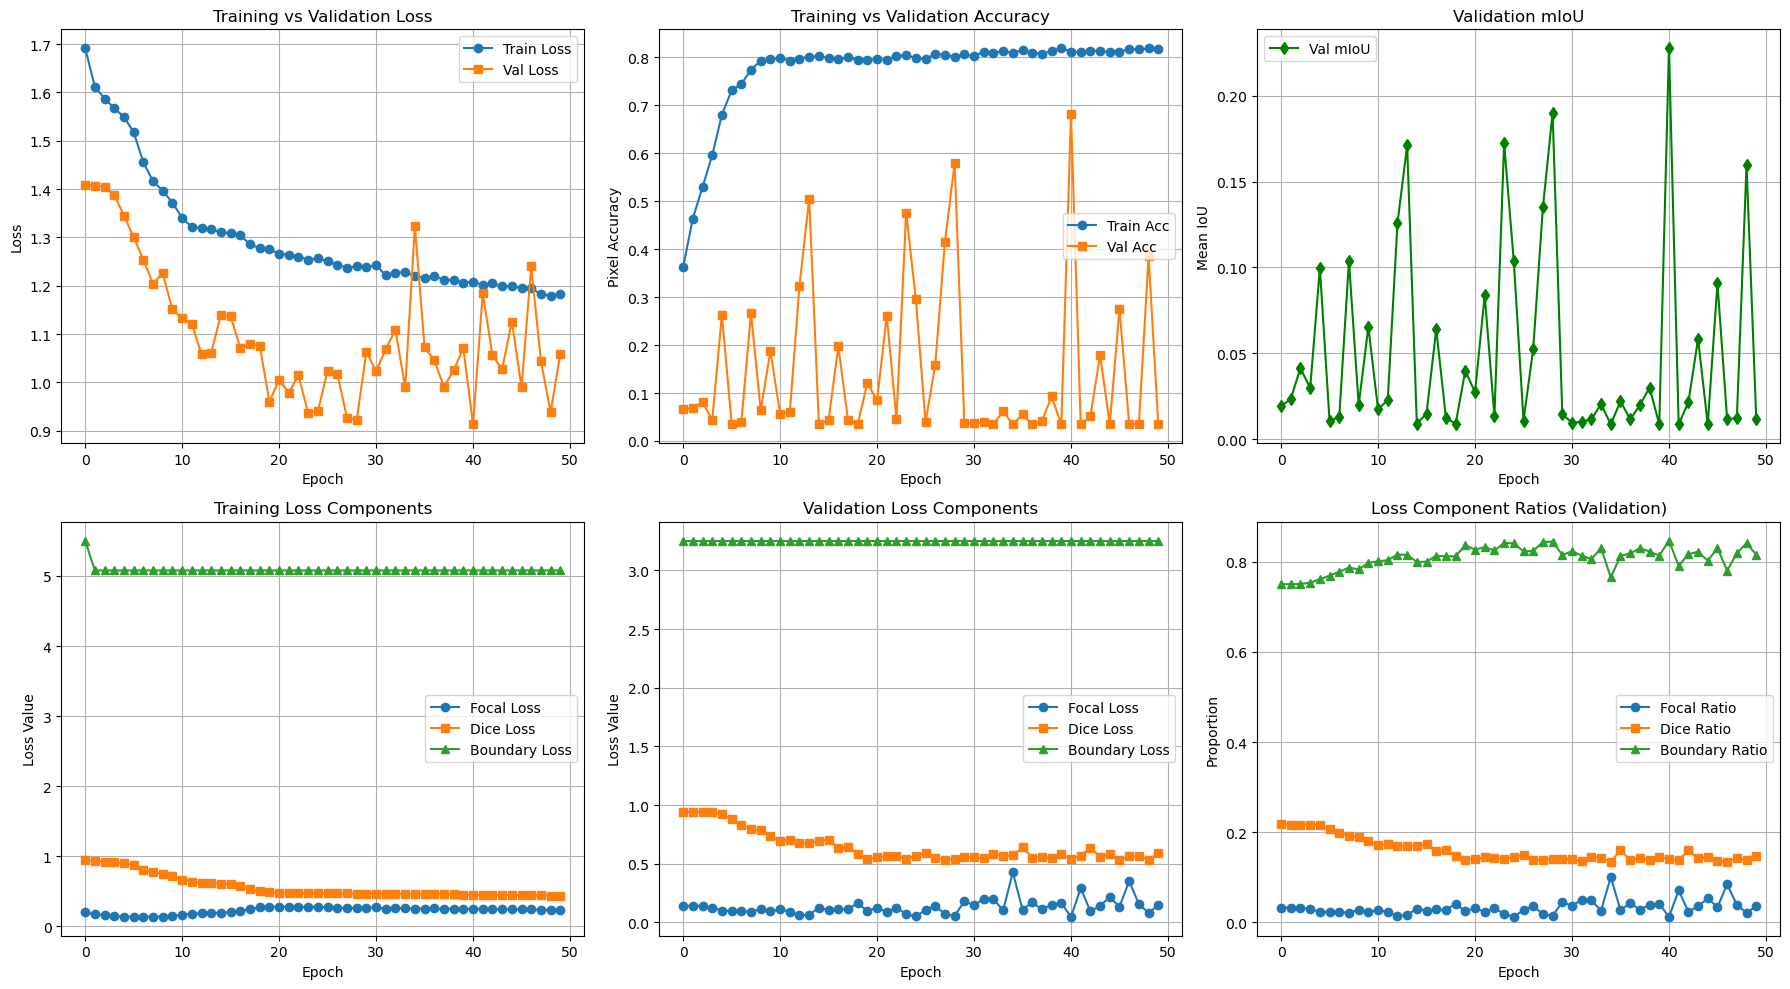

In [11]:
# ===========================================
# Cell 11. Plot Training History (Enhanced)
# ===========================================

fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Loss
axes[0, 0].plot(history["train_loss"], label="Train Loss", marker='o')
axes[0, 0].plot(history["val_loss"], label="Val Loss", marker='s')
axes[0, 0].set_xlabel("Epoch")
axes[0, 0].set_ylabel("Loss")
axes[0, 0].set_title("Training vs Validation Loss")
axes[0, 0].legend()
axes[0, 0].grid(True)

# Accuracy
axes[0, 1].plot(history["train_acc"], label="Train Acc", marker='o')
axes[0, 1].plot(history["val_acc"], label="Val Acc", marker='s')
axes[0, 1].set_xlabel("Epoch")
axes[0, 1].set_ylabel("Pixel Accuracy")
axes[0, 1].set_title("Training vs Validation Accuracy")
axes[0, 1].legend()
axes[0, 1].grid(True)

# mIoU
axes[0, 2].plot(history["val_miou"], label="Val mIoU", marker='d', color='green')
axes[0, 2].set_xlabel("Epoch")
axes[0, 2].set_ylabel("Mean IoU")
axes[0, 2].set_title("Validation mIoU")
axes[0, 2].legend()
axes[0, 2].grid(True)

# Loss Components - Training
axes[1, 0].plot(history["train_loss_focal"], label="Focal Loss", marker='o')
axes[1, 0].plot(history["train_loss_dice"], label="Dice Loss", marker='s')
axes[1, 0].plot(history["train_loss_boundary"], label="Boundary Loss", marker='^')
axes[1, 0].set_xlabel("Epoch")
axes[1, 0].set_ylabel("Loss Value")
axes[1, 0].set_title("Training Loss Components")
axes[1, 0].legend()
axes[1, 0].grid(True)

# Loss Components - Validation
axes[1, 1].plot(history["val_loss_focal"], label="Focal Loss", marker='o')
axes[1, 1].plot(history["val_loss_dice"], label="Dice Loss", marker='s')
axes[1, 1].plot(history["val_loss_boundary"], label="Boundary Loss", marker='^')
axes[1, 1].set_xlabel("Epoch")
axes[1, 1].set_ylabel("Loss Value")
axes[1, 1].set_title("Validation Loss Components")
axes[1, 1].legend()
axes[1, 1].grid(True)

# Loss ratio analysis
if len(history["val_loss_focal"]) > 0:
    total = np.array(history["val_loss_focal"]) + np.array(history["val_loss_dice"]) + np.array(history["val_loss_boundary"])
    focal_ratio = np.array(history["val_loss_focal"]) / (total + 1e-9)
    dice_ratio = np.array(history["val_loss_dice"]) / (total + 1e-9)
    bnd_ratio = np.array(history["val_loss_boundary"]) / (total + 1e-9)
    
    axes[1, 2].plot(focal_ratio, label="Focal Ratio", marker='o')
    axes[1, 2].plot(dice_ratio, label="Dice Ratio", marker='s')
    axes[1, 2].plot(bnd_ratio, label="Boundary Ratio", marker='^')
    axes[1, 2].set_xlabel("Epoch")
    axes[1, 2].set_ylabel("Proportion")
    axes[1, 2].set_title("Loss Component Ratios (Validation)")
    axes[1, 2].legend()
    axes[1, 2].grid(True)

plt.tight_layout()
plt.savefig("training_history_ver4_enhanced.png", dpi=150)
plt.show()


Visualizing spectral attention weights...


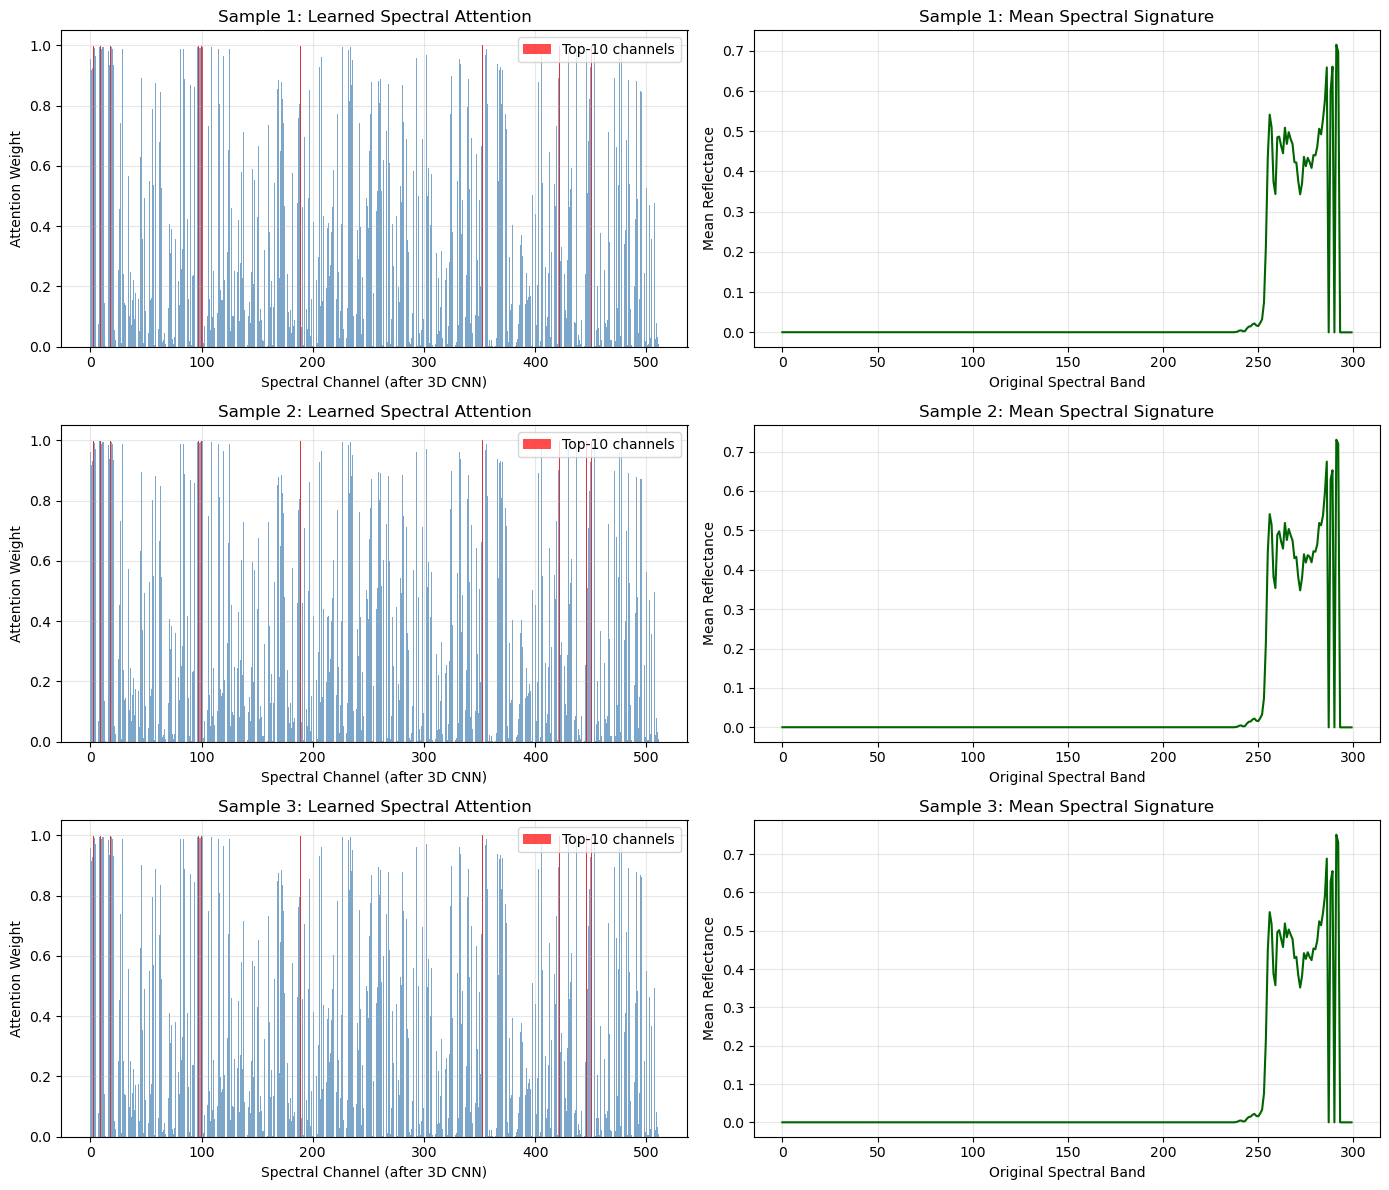


SPECTRAL ATTENTION ANALYSIS

Sample 1:
  Mean attention: 0.3855
  Std attention: 0.3411
  Max attention: 0.9993
  Top-5 channels: [ 97   3 100   9 353] with weights [0.9983157 0.9987257 0.9987393 0.9988895 0.9993405]

Sample 2:
  Mean attention: 0.3864
  Std attention: 0.3437
  Max attention: 0.9994
  Top-5 channels: [ 97   3 100   9 353] with weights [0.9985347  0.9987696  0.9988005  0.99896705 0.999363  ]

Sample 3:
  Mean attention: 0.3858
  Std attention: 0.3424
  Max attention: 0.9994
  Top-5 channels: [ 97   3 100   9 353] with weights [0.99846184 0.99875677 0.9987853  0.9989311  0.9993678 ]


In [12]:
# ===========================================
# Cell 12. Spectral Attention Visualization
# ===========================================

def visualize_spectral_attention(model, loader, num_samples=3):
    """Visualize learned spectral attention weights"""
    model.eval()
    
    attention_weights_list = []
    sample_images = []
    
    with torch.no_grad():
        for i, (xb, yb) in enumerate(loader):
            if i >= num_samples:
                break
            
            xb = xb.to(device)
            _ = model(xb)  # Forward pass
            
            # Get attention weights
            attn_weights = model.get_attention_weights()
            if attn_weights is not None:
                attention_weights_list.append(attn_weights[0].cpu().numpy())
                sample_images.append(xb[0])
    
    if not attention_weights_list:
        print("No attention weights captured!")
        return
    
    # Plot attention weights
    fig, axes = plt.subplots(num_samples, 2, figsize=(14, 4*num_samples))
    
    for i in range(num_samples):
        # Attention weights
        attn = attention_weights_list[i]
        axes[i, 0].bar(range(len(attn)), attn, color='steelblue', alpha=0.7)
        axes[i, 0].set_xlabel("Spectral Channel (after 3D CNN)")
        axes[i, 0].set_ylabel("Attention Weight")
        axes[i, 0].set_title(f"Sample {i+1}: Learned Spectral Attention")
        axes[i, 0].grid(True, alpha=0.3)
        
        # Top-k important channels
        top_k = 10
        top_indices = np.argsort(attn)[-top_k:]
        axes[i, 0].bar(top_indices, attn[top_indices], color='red', alpha=0.7, 
                       label=f'Top-{top_k} channels')
        axes[i, 0].legend()
        
        # Original hyperspectral signature (averaged)
        img = sample_images[i].cpu().numpy()  # [Bands, H, W]
        mean_spectrum = img.mean(axis=(1, 2))
        
        axes[i, 1].plot(mean_spectrum, color='darkgreen', linewidth=1.5)
        axes[i, 1].set_xlabel("Original Spectral Band")
        axes[i, 1].set_ylabel("Mean Reflectance")
        axes[i, 1].set_title(f"Sample {i+1}: Mean Spectral Signature")
        axes[i, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig("spectral_attention_weights_ver4.png", dpi=150)
    plt.show()
    
    # Print statistics
    print("\n" + "="*60)
    print("SPECTRAL ATTENTION ANALYSIS")
    print("="*60)
    for i, attn in enumerate(attention_weights_list):
        top_5_idx = np.argsort(attn)[-5:]
        print(f"\nSample {i+1}:")
        print(f"  Mean attention: {attn.mean():.4f}")
        print(f"  Std attention: {attn.std():.4f}")
        print(f"  Max attention: {attn.max():.4f}")
        print(f"  Top-5 channels: {top_5_idx} with weights {attn[top_5_idx]}")

# Visualize attention on validation set
print("\nVisualizing spectral attention weights...")
visualize_spectral_attention(model, val_loader, num_samples=3)

C:\Users\admin\AppData\Local\Temp\ipykernel_10876\349954092.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_checkpoint = torch.load(best_model_path, map_location=de

Loaded best model from epoch 41



TEST RESULTS
Test Loss     : 0.7838
  ├─ Focal Loss  : 0.1342
  ├─ Dice Loss: 0.5478
  └─ Bnd Loss : 1.0183
Test Accuracy : 0.3736
Test mIoU     : 0.1272
IoU per class : [0.         0.         0.01206398 0.         0.         0.36960042]

GENERATING SEGMENTATION MAPS
Sample 1: Input shape torch.Size([1, 300, 64, 64]), Output shape torch.Size([1, 64, 64])
Sample 2: Input shape torch.Size([1, 300, 64, 64]), Output shape torch.Size([1, 64, 64])
Sample 3: Input shape torch.Size([1, 300, 64, 64]), Output shape torch.Size([1, 64, 64])
Sample 4: Input shape torch.Size([1, 300, 64, 64]), Output shape torch.Size([1, 64, 64])
Sample 5: Input shape torch.Size([1, 300, 64, 64]), Output shape torch.Size([1, 64, 64])

Generating visualizations...
Visualizing sample 1/5


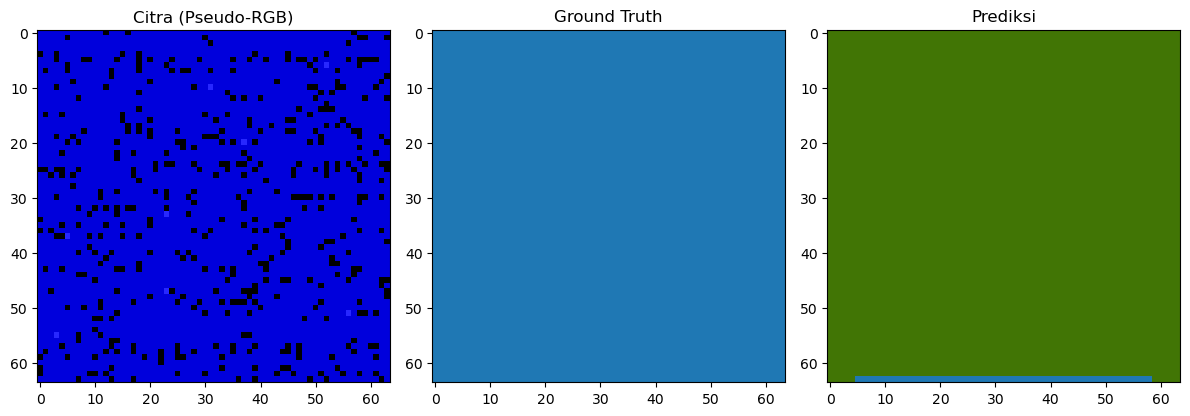

Visualizing sample 2/5


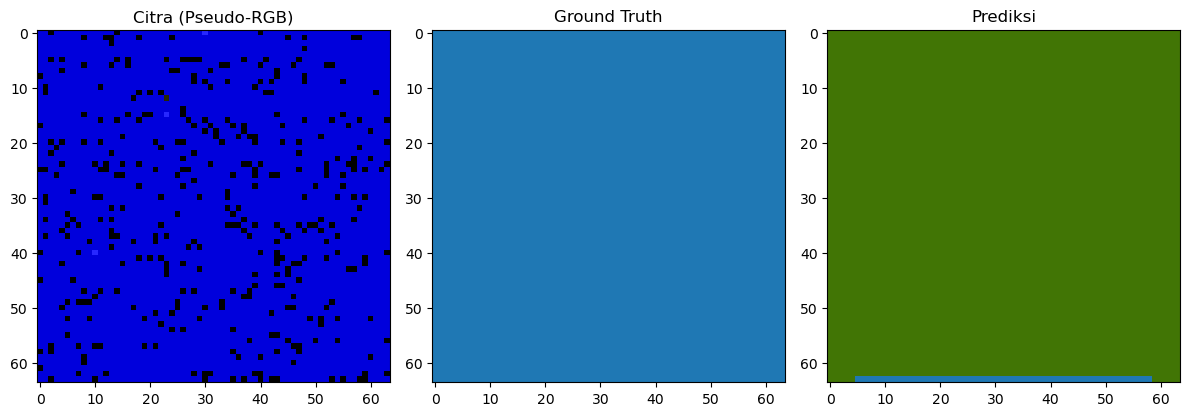

Visualizing sample 3/5


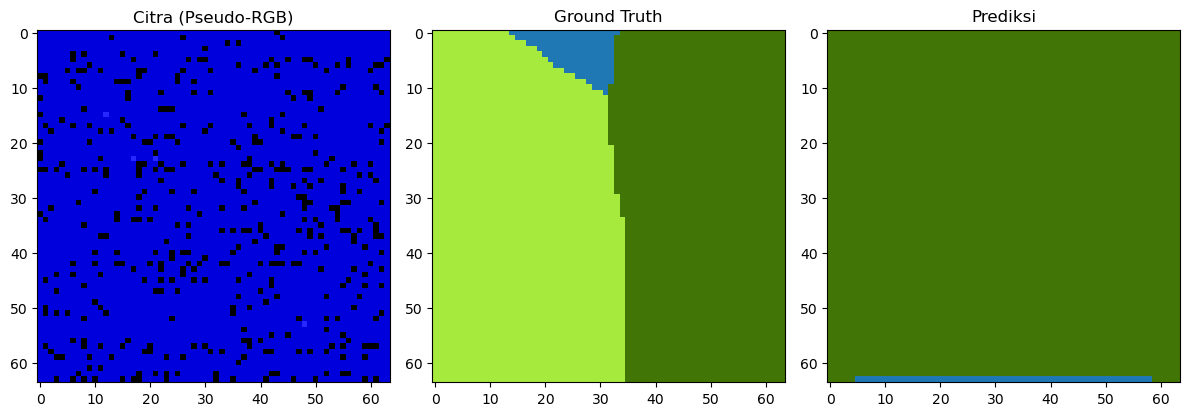

Visualizing sample 4/5


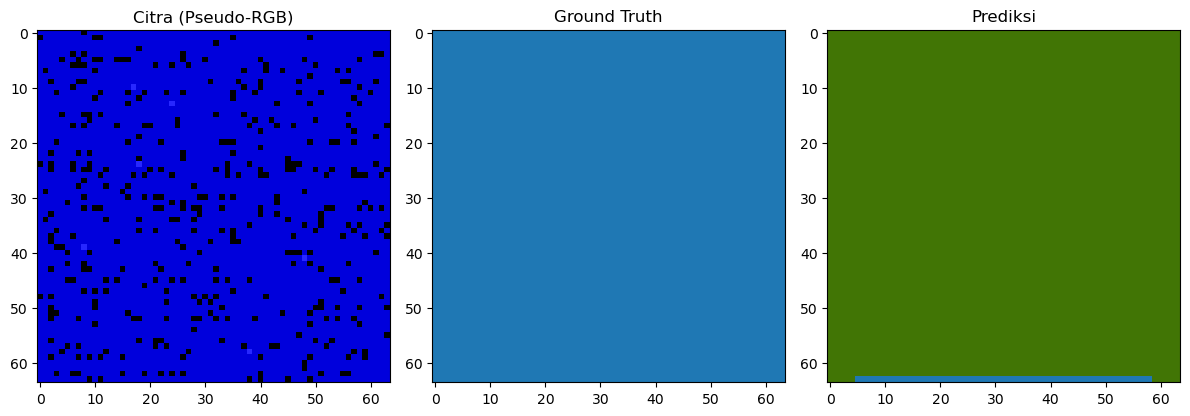

Visualizing sample 5/5


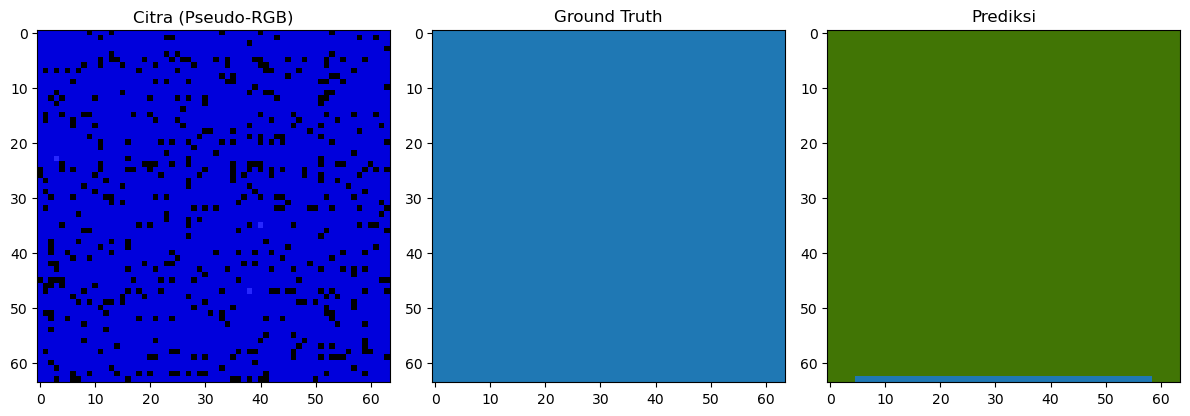


[OK] Output: SEGMENTATION MAPS
  Format: [H, W] dengan setiap pixel berisi class label (0-6)
  Visualisasi: Setiap warna merepresentasikan habitat class berbeda


In [13]:
# ===========================================
# Cell 13. Testing dan Visualisasi Output Segmentation
# ===========================================

# Load best model
best_checkpoint = torch.load(best_model_path, map_location=device)
model.load_state_dict(best_checkpoint["model_state"])
print(f"Loaded best model from epoch {best_checkpoint['epoch']}")

# Test evaluation
test_metrics = SegmentationMetrics(num_classes_actual, ignore_index=0)
test_loss, test_acc, test_miou, test_iou_per_class, test_focal, test_dice, test_bnd = validate(
    model, test_loader, criterion, test_metrics, device
)

print("\n" + "="*60)
print("TEST RESULTS")
print("="*60)
print(f"Test Loss     : {test_loss:.4f}")
print(f"  ├─ Focal Loss  : {test_focal:.4f}") # rename ce menjadi focal 
print(f"  ├─ Dice Loss: {test_dice:.4f}")
print(f"  └─ Bnd Loss : {test_bnd:.4f}")
print(f"Test Accuracy : {test_acc:.4f}")
print(f"Test mIoU     : {test_miou:.4f}")
print(f"IoU per class : {test_iou_per_class[1:]}")

# Visualisasi beberapa prediksi SEGMENTATION MAP
model.eval()
num_vis = 5
vis_samples = []

print("\n" + "="*60)
print("GENERATING SEGMENTATION MAPS")
print("="*60)

with torch.no_grad():
    for i, (xb, yb) in enumerate(test_loader):
        if i >= num_vis:
            break
        xb = xb.to(device)
        logits = model(xb)
        preds = logits.argmax(dim=1)  # [B, H, W] - SEGMENTATION MAP
        
        vis_samples.append((xb[0], yb[0], preds[0]))
        print(f"Sample {i+1}: Input shape {xb.shape}, Output shape {preds.shape}")

# Plot visualisasi segmentation maps
print("\nGenerating visualizations...")
for i, (x, y_true, y_pred) in enumerate(vis_samples):
    print(f"Visualizing sample {i+1}/{num_vis}")
    visualize_tile(x, y_true.cpu().numpy(), y_pred.cpu().numpy(), 
                   json_path=label_json_path, idx=i)

print("\n[OK] Output: SEGMENTATION MAPS")
print("  Format: [H, W] dengan setiap pixel berisi class label (0-6)")
print("  Visualisasi: Setiap warna merepresentasikan habitat class berbeda")

Computing CM: 100%|██████████████████████████████████████████████████████████████████| 437/437 [00:08<00:00, 49.26it/s]


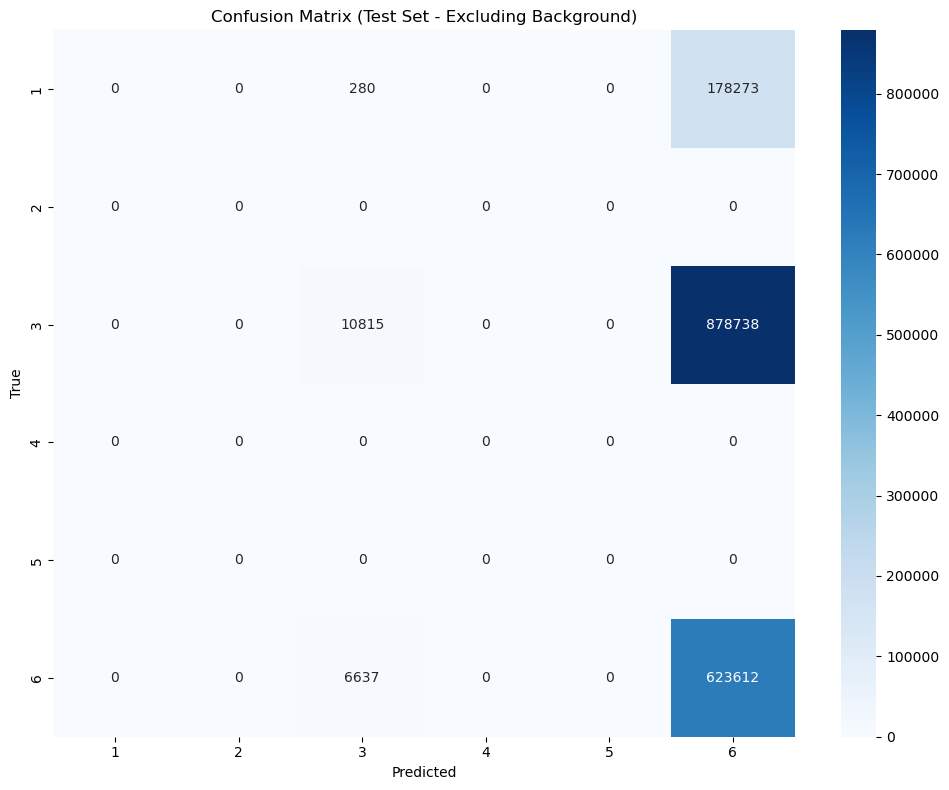

Confusion matrix saved!


In [14]:
# ===========================================
# Cell 14. Confusion Matrix
# ===========================================

from sklearn.metrics import confusion_matrix
import seaborn as sns

# Collect predictions untuk confusion matrix
all_preds = []
all_targets = []

model.eval()
with torch.no_grad():
    for xb, yb in tqdm(test_loader, desc="Computing CM"):
        xb = xb.to(device)
        logits = model(xb)
        preds = logits.argmax(dim=1)
        
        # Flatten dan filter valid pixels
        preds_flat = preds.cpu().numpy().flatten()
        targets_flat = yb.numpy().flatten()
        
        valid = targets_flat != 0  # Exclude background
        all_preds.extend(preds_flat[valid])
        all_targets.extend(targets_flat[valid])

# Compute confusion matrix
cm = confusion_matrix(all_targets, all_preds, labels=list(range(1, num_classes_actual)))

# Plot
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=range(1, num_classes_actual),
            yticklabels=range(1, num_classes_actual))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (Test Set - Excluding Background)')
plt.tight_layout()
plt.savefig('confusion_matrix_ver4.png', dpi=150)
plt.show()

print("Confusion matrix saved!")


FULL IMAGE SEGMENTATION
Selected image: massimal_smola_maholmen_202306211228-2_hsi_020_processed_x.npy
[INFO] Loading full image from: ../data/npy_converted\massimal_smola_maholmen_202306211228-2_hsi_020_processed_x.npy
[INFO] Image shape: (2000, 900, 300)
[INFO] Processing 1647 tiles (61x27)...
  Processed 100/1647 tiles (6.1%)
  Processed 200/1647 tiles (12.1%)
  Processed 300/1647 tiles (18.2%)
  Processed 400/1647 tiles (24.3%)
  Processed 500/1647 tiles (30.4%)
  Processed 600/1647 tiles (36.4%)
  Processed 700/1647 tiles (42.5%)
  Processed 800/1647 tiles (48.6%)
  Processed 900/1647 tiles (54.6%)
  Processed 1000/1647 tiles (60.7%)
  Processed 1100/1647 tiles (66.8%)
  Processed 1200/1647 tiles (72.9%)
  Processed 1300/1647 tiles (78.9%)
  Processed 1400/1647 tiles (85.0%)
  Processed 1500/1647 tiles (91.1%)
  Processed 1600/1647 tiles (97.1%)
[INFO] Segmentation complete!
[INFO] Unique classes predicted: [0 3 6]
[INFO] Ground truth loaded. Unique classes: [ 0 13 38]

[METRICS]

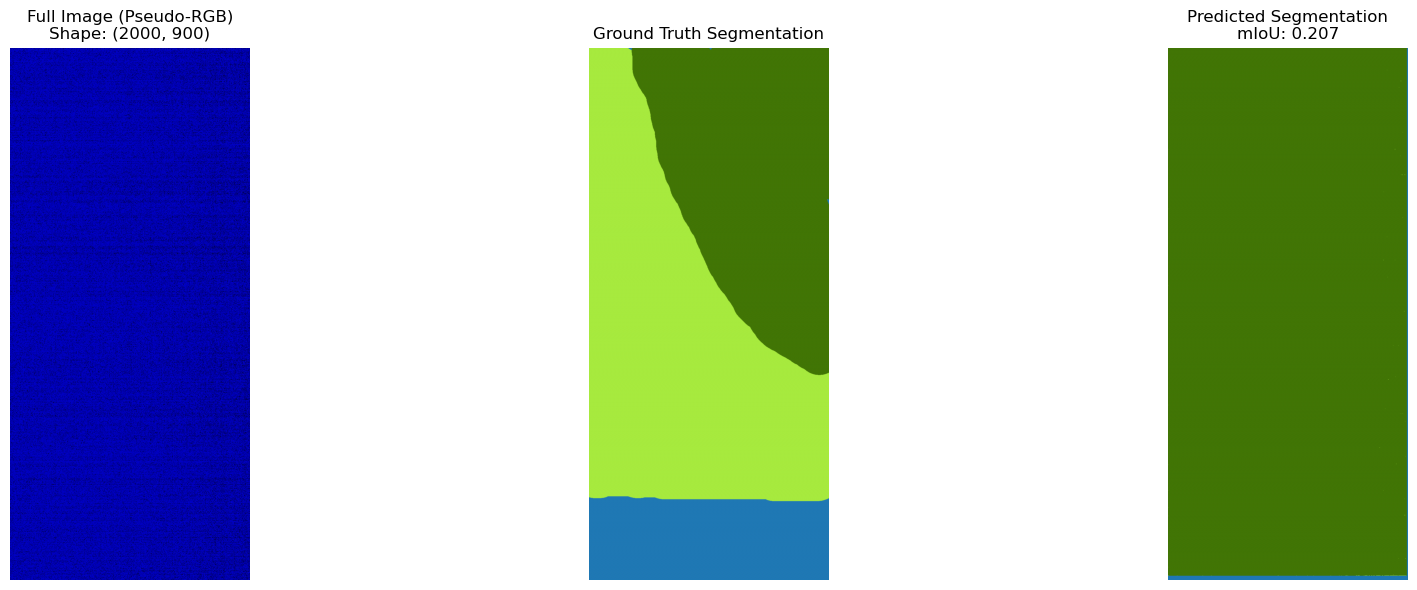


[OK] Full image segmentation saved!
  Resolution: (2000, 900)
  File: full_image_segmentation_ver4.png

BATCH FULL IMAGE SEGMENTATION (ALL TEST IMAGES)

Processing image 1/2: massimal_smola_maholmen_202306211228-2_hsi_020_processed_x.npy
[INFO] Loading full image from: ../data/npy_converted\massimal_smola_maholmen_202306211228-2_hsi_020_processed_x.npy
[INFO] Image shape: (2000, 900, 300)
[INFO] Processing 1647 tiles (61x27)...
  Processed 100/1647 tiles (6.1%)
  Processed 200/1647 tiles (12.1%)
  Processed 300/1647 tiles (18.2%)
  Processed 400/1647 tiles (24.3%)
  Processed 500/1647 tiles (30.4%)
  Processed 600/1647 tiles (36.4%)
  Processed 700/1647 tiles (42.5%)
  Processed 800/1647 tiles (48.6%)
  Processed 900/1647 tiles (54.6%)
  Processed 1000/1647 tiles (60.7%)
  Processed 1100/1647 tiles (66.8%)
  Processed 1200/1647 tiles (72.9%)
  Processed 1300/1647 tiles (78.9%)
  Processed 1400/1647 tiles (85.0%)
  Processed 1500/1647 tiles (91.1%)
  Processed 1600/1647 tiles (97.1%)
[

In [15]:
# ===========================================
# Cell 15. Full Image Segmentation with Sliding Window
# ===========================================

def segment_full_image(model, image_path, mask_path=None, tile_size=64, stride=32, device='cuda'):
    """
    Segmentasi full image dengan sliding window approach
    
    Args:
        model: trained segmentation model
        image_path: path ke file _x.npy
        mask_path: path ke file _y.npy (optional, untuk comparison)
        tile_size: ukuran tile untuk inference
        stride: step size untuk sliding window (stride < tile_size untuk smooth overlap)
        device: 'cuda' or 'cpu'
    
    Returns:
        prediction_map: segmentation result [H, W]
        full_image: original image [H, W, Bands]
        ground_truth: GT mask if mask_path provided, else None
    """
    model.eval()
    
    print(f"[INFO] Loading full image from: {image_path}")
    
    # Load full image
    x_full = np.load(image_path, mmap_mode='r')  # [H, W, Bands]
    H, W, B = x_full.shape
    print(f"[INFO] Image shape: {x_full.shape}")
    
    # Normalize
    x_full_norm = normalize_reflectance(x_full.copy())
    
    # Prepare output with soft voting
    prediction_accumulator = np.zeros((num_classes_actual, H, W), dtype=np.float32)
    count_map = np.zeros((H, W), dtype=np.float32)
    
    # Calculate number of tiles
    n_tiles_h = (H - tile_size) // stride + 1
    n_tiles_w = (W - tile_size) // stride + 1
    total_tiles = n_tiles_h * n_tiles_w
    
    print(f"[INFO] Processing {total_tiles} tiles ({n_tiles_h}x{n_tiles_w})...")
    
    with torch.no_grad():
        tile_count = 0
        for i in range(0, H - tile_size + 1, stride):
            for j in range(0, W - tile_size + 1, stride):
                # Extract tile
                tile = x_full_norm[i:i+tile_size, j:j+tile_size, :]
                tile_tensor = torch.from_numpy(tile.transpose(2,0,1)).unsqueeze(0).float().to(device)
                
                # Predict
                logits = model(tile_tensor)  # [1, C, H, W]
                probs = F.softmax(logits, dim=1).squeeze(0).cpu().numpy()  # [C, H, W]
                
                # Accumulate predictions (soft voting)
                prediction_accumulator[:, i:i+tile_size, j:j+tile_size] += probs
                count_map[i:i+tile_size, j:j+tile_size] += 1
                
                tile_count += 1
                if tile_count % 100 == 0:
                    print(f"  Processed {tile_count}/{total_tiles} tiles ({tile_count/total_tiles*100:.1f}%)")
    
    # Average overlapping predictions and get argmax
    prediction_accumulator /= (count_map[np.newaxis, :, :] + 1e-9)
    final_pred = prediction_accumulator.argmax(axis=0).astype(np.int32)
    
    print(f"[INFO] Segmentation complete!")
    print(f"[INFO] Unique classes predicted: {np.unique(final_pred)}")
    
    # Load ground truth if provided
    ground_truth = None
    if mask_path and os.path.exists(mask_path):
        ground_truth = np.load(mask_path)
        print(f"[INFO] Ground truth loaded. Unique classes: {np.unique(ground_truth)}")
        
        # Remap ground truth
        if label_remap is not None:
            gt_remap = np.zeros_like(ground_truth, dtype=np.int32)
            for orig_label, new_idx in label_remap.items():
                gt_remap[ground_truth == orig_label] = new_idx
            ground_truth = gt_remap
    
    return final_pred, x_full, ground_truth


# Visualize full image segmentation
print("\n" + "="*60)
print("FULL IMAGE SEGMENTATION")
print("="*60)

# Select a test image
test_file_idx = 0  # Change this to visualize different images
test_file_x = test_pairs[test_file_idx][0]
test_file_y = test_pairs[test_file_idx][1]

print(f"Selected image: {os.path.basename(test_file_x)}")

# Perform segmentation
full_pred, full_img, full_gt = segment_full_image(
    model, 
    test_file_x, 
    test_file_y,
    tile_size=TILE_SIZE, 
    stride=TILE_SIZE // 2,  # 50% overlap
    device=device
)

# Calculate metrics for full image
if full_gt is not None:
    valid_mask = (full_gt != 0)
    if valid_mask.sum() > 0:
        valid_pred = full_pred[valid_mask]
        valid_gt = full_gt[valid_mask]
        
        full_acc = (valid_pred == valid_gt).sum() / len(valid_pred)
        
        # Calculate IoU per class
        full_iou_per_class = []
        for cls in range(1, num_classes_actual):
            pred_i = (valid_pred == cls)
            gt_i = (valid_gt == cls)
            intersection = (pred_i & gt_i).sum()
            union = (pred_i | gt_i).sum()
            iou = intersection / (union + 1e-9) if union > 0 else 0.0
            full_iou_per_class.append(iou)
        
        full_miou = np.mean([iou for iou in full_iou_per_class if iou > 0])
        
        print(f"\n[METRICS] Full Image:")
        print(f"  Pixel Accuracy: {full_acc:.4f}")
        print(f"  Mean IoU: {full_miou:.4f}")
        print(f"  IoU per class: {full_iou_per_class}")

# Visualize
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# Pseudo-RGB
rgb_idx = [int(full_img.shape[2]*0.05), int(full_img.shape[2]*0.5), int(full_img.shape[2]*0.9)]
rgb = full_img[..., rgb_idx]
rgb_norm = (rgb - rgb.min()) / (rgb.max() - rgb.min() + 1e-9)

# Load colormap
if os.path.exists(label_json_path):
    with open(label_json_path, "r") as f:
        label_info = json.load(f)
    custom_colors = [c["color"][:7] for c in label_info]
    cmap = ListedColormap(custom_colors)
else:
    cmap = "tab20"

axes[0].imshow(rgb_norm)
axes[0].set_title(f"Full Image (Pseudo-RGB)\nShape: {full_img.shape[:2]}", fontsize=12)
axes[0].axis('off')

if full_gt is not None:
    axes[1].imshow(full_gt, cmap=cmap, vmin=0, vmax=num_classes_actual-1)
    axes[1].set_title("Ground Truth Segmentation", fontsize=12)
    axes[1].axis('off')

axes[2].imshow(full_pred, cmap=cmap, vmin=0, vmax=num_classes_actual-1)
axes[2].set_title(f"Predicted Segmentation\nmIoU: {full_miou:.3f}" if full_gt is not None else "Predicted Segmentation", fontsize=12)
axes[2].axis('off')

plt.tight_layout()
plt.savefig('full_image_segmentation_ver4.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\n[OK] Full image segmentation saved!")
print(f"  Resolution: {full_pred.shape}")
print(f"  File: full_image_segmentation_ver4.png")


# Optional: Visualize multiple test images
print("\n" + "="*60)
print("BATCH FULL IMAGE SEGMENTATION (ALL TEST IMAGES)")
print("="*60)

for idx, (fx, fy) in enumerate(test_pairs):
    print(f"\nProcessing image {idx+1}/{len(test_pairs)}: {os.path.basename(fx)}")
    
    pred, img, gt = segment_full_image(
        model, fx, fy,
        tile_size=TILE_SIZE,
        stride=TILE_SIZE // 2,
        device=device
    )
    
    # Create visualization
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    rgb_idx = [int(img.shape[2]*0.05), int(img.shape[2]*0.5), int(img.shape[2]*0.9)]
    rgb = img[..., rgb_idx]
    rgb_norm = (rgb - rgb.min()) / (rgb.max() - rgb.min() + 1e-9)
    
    axes[0].imshow(rgb_norm)
    axes[0].set_title(f"Image {idx+1}: Pseudo-RGB")
    axes[0].axis('off')
    
    if gt is not None:
        axes[1].imshow(gt, cmap=cmap)
        axes[1].set_title("Ground Truth")
        axes[1].axis('off')
    
    axes[2].imshow(pred, cmap=cmap)
    axes[2].set_title("Prediction")
    axes[2].axis('off')
    
    plt.tight_layout()
    plt.savefig(f'full_image_seg_test_{idx+1}.png', dpi=120, bbox_inches='tight')
    plt.close()
    
    print(f"  [OK] Saved: full_image_seg_test_{idx+1}.png")

print("\n[OK] All test images processed!")
print(f"[OK] Generated {len(test_pairs)} full segmentation maps")


In [16]:
# ===========================================
# Cell 15b. Dataset Distribution Analysis (untuk solusi test set issue)
# ===========================================

print("\n" + "="*60)
print("DATASET CLASS DISTRIBUTION ANALYSIS")
print("="*60)

def analyze_file_distribution(pairs, split_name):
    """Analisis distribusi kelas per file"""
    print(f"\n{split_name} Split Analysis:")
    print(f"{'='*50}")
    
    file_class_info = []
    
    for idx, (fx, fy) in enumerate(pairs):
        y = np.load(fy, mmap_mode='r')
        unique, counts = np.unique(y, return_counts=True)
        
        # Convert to dict
        class_dist = dict(zip(unique.tolist(), counts.tolist()))
        
        # Get remapped classes
        remapped_dist = {}
        for orig, cnt in class_dist.items():
            if orig in label_remap:
                new_idx = label_remap[orig]
                remapped_dist[new_idx] = cnt
        
        file_class_info.append({
            'file': os.path.basename(fx),
            'distribution': remapped_dist,
            'classes_present': sorted(remapped_dist.keys())
        })
        
        print(f"\nFile {idx+1}: {os.path.basename(fx)}")
        print(f"  Classes present: {sorted(remapped_dist.keys())}")
        print(f"  Pixel counts: {remapped_dist}")
    
    # Summary
    all_classes = set()
    for info in file_class_info:
        all_classes.update(info['classes_present'])
    
    print(f"\n{split_name} Summary:")
    print(f"  Total files: {len(pairs)}")
    print(f"  Classes covered: {sorted(all_classes)}")
    print(f"  Missing classes: {set(range(num_classes_actual)) - all_classes}")
    
    return file_class_info

# Analyze all splits
train_analysis = analyze_file_distribution(train_pairs, "TRAIN")
val_analysis = analyze_file_distribution(val_pairs, "VALIDATION")
test_analysis = analyze_file_distribution(test_pairs, "TEST")

# Check coverage
print("\n" + "="*60)
print("OVERALL COVERAGE CHECK")
print("="*60)

all_train_classes = set()
all_val_classes = set()
all_test_classes = set()

for info in train_analysis:
    all_train_classes.update(info['classes_present'])
for info in val_analysis:
    all_val_classes.update(info['classes_present'])
for info in test_analysis:
    all_test_classes.update(info['classes_present'])

print(f"\nClasses in Train: {sorted(all_train_classes)}")
print(f"Classes in Val:   {sorted(all_val_classes)}")
print(f"Classes in Test:  {sorted(all_test_classes)}")

missing_in_test = all_train_classes - all_test_classes
if missing_in_test:
    print(f"\n [WARNING]: Classes {sorted(missing_in_test)} are in TRAIN but NOT in TEST!")
    print(f"   This means we cannot evaluate model performance on these classes.")
    
    # Suggest rebalancing
    print(f"\n💡 RECOMMENDATION:")
    print(f"   Option 1: Move files from train/val to test that contain classes {sorted(missing_in_test)}")
    
    # Find files in train that have missing classes
    candidate_files = []
    for info in train_analysis:
        if missing_in_test & set(info['classes_present']):
            candidate_files.append((info['file'], info['classes_present']))
    
    if candidate_files:
        print(f"\n   Candidate files to move to test set:")
        for fname, classes in candidate_files[:3]:  # Show top 3
            print(f"     - {fname}: has classes {sorted(classes)}")
else:
    print(f"\n✓ All classes are represented in test set!")


DATASET CLASS DISTRIBUTION ANALYSIS

TRAIN Split Analysis:

File 1: massimal_smola_maholmen_202306211129-2_hsi_003_processed_x.npy
  Classes present: [0, 3, 4, 5, 6]
  Pixel counts: {0: 988860, 3: 562600, 4: 36978, 5: 139337, 6: 72225}

File 2: massimal_smola_maholmen_202306211129-2_hsi_004_processed_x.npy
  Classes present: [0, 2]
  Pixel counts: {0: 1685120, 2: 114880}

File 3: massimal_smola_maholmen_202306211129-2_hsi_008_processed_x.npy
  Classes present: [0, 2]
  Pixel counts: {0: 1261804, 2: 538196}

File 4: massimal_smola_maholmen_202306211129-2_hsi_009_processed_x.npy
  Classes present: [0, 2]
  Pixel counts: {0: 1521058, 2: 278942}

File 5: massimal_smola_maholmen_202306211129-2_hsi_013_processed_x.npy
  Classes present: [0, 1]
  Pixel counts: {0: 1725410, 1: 74590}

File 6: massimal_smola_maholmen_202306211228-2_hsi_004_processed_x.npy
  Classes present: [0, 1]
  Pixel counts: {0: 1689194, 1: 110806}

File 7: massimal_smola_maholmen_202306211228-2_hsi_005_processed_x.npy
  

In [17]:
# ===========================================
# Cell 17. Save Results Summary
# ===========================================

results_summary = {
    "model": "SpectralAttentionHybridSN",
    "version": "v4_improved",
    "novelties": ["Spectral Self-Attention", "Multi-Objective Loss (Focal+Dice+Boundary)"],
    "improvements": [
        "Learning rate: 5e-6 → 1e-4",
        "Tile size: 32 → 64",
        "Boundary loss weight: 0.5 → 0.1",
        "Data augmentation: flip + rotation",
        "Focal loss replacing CE",
        "Early stopping patience: 10 → 15"
    ],
    "hyperparameters": {
        "learning_rate": LR,
        "batch_size": BATCH_SIZE,
        "accumulation_steps": ACCUMULATION_STEPS,
        "tile_size": TILE_SIZE,
        "num_epochs": NUM_EPOCHS,
        "attention_reduction": 16,
        "loss_weights": {"focal": 1.0, "dice": 1.0, "boundary": 0.1},
        "focal_gamma": 2.0,
        "early_stopping_patience": 15
    },
    "test_results": {
        "pixel_accuracy": float(test_acc),
        "mean_iou": float(test_miou),
        "loss_total": float(test_loss),
        "loss_focal": float(test_focal),
        "loss_dice": float(test_dice),
        "loss_boundary": float(test_bnd),
        "iou_per_class": test_iou_per_class.tolist()
    },
    "training_history": history
}

# Save to JSON
with open("results_ver4_summary.json", "w") as f:
    json.dump(results_summary, f, indent=2)

print("\n" + "="*60)
print("EXPERIMENT SUMMARY")
print("="*60)
print(json.dumps(results_summary["test_results"], indent=2))
print("\nResults saved to: results_ver4_summary.json")
print("\n[OK]Training complete!")


EXPERIMENT SUMMARY
{
  "pixel_accuracy": 0.3735538211975704,
  "mean_iou": 0.1272214666629831,
  "loss_total": 0.7837949568401485,
  "loss_focal": 0.13418548073922232,
  "loss_dice": 0.5477815750534529,
  "loss_boundary": 1.0182789945181083,
  "iou_per_class": [
    0.0,
    0.0,
    0.0,
    0.012063984759151936,
    0.0,
    0.0,
    0.36960041522979736
  ]
}

Results saved to: results_ver4_summary.json

[OK]Training complete!
